In [1]:
# Подгрузка библиотек

In [2]:
import csv
import os
import numpy as np
import pandas as pd
from collections import Counter
import re

import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

import warnings

warnings.filterwarnings('ignore')

In [3]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# df_path = '/content/drive/MyDrive/hacaton_1/SERGEY'

In [4]:
df_path = './data-copy'

In [5]:
tqdm.pandas(desc="Processing rows...", ncols=100)

# 1. Загрузка данных

Исходный набор представляет собой открытые данные [Государственного каталога музейного фонда РФ Министерства культуры РФ](https://opendata.mkrf.ru/opendata/7705851331-museum-exhibits)

In [6]:
# Подгрузка данных
data = pd.read_csv(f'{df_path}/Russian_museum.csv', sep=';', encoding='utf-8')
data.head()

,Наименование предмета,Автор,Музей,Items,Дата создания предмета (строка),Место создания,Строковое описание размеров,Описание,Количество составляющих,Изображение,...,Длина,Единица измерения размера,Интервал времени создания предмета (начало),Интервал времени создания предмета (окончание),"Точность задания времени (день, месяц, год, век, эпоха).",URL предмета на сайте музея,Ключевые слова,Краткое описание истории бытования (провенанс) предмета,Идентификатор статуса предмета,Типология
0,Декоративный мотив.,"[""Малевич Казимир Северинович 1879-1935""]",Федеральное государственное бюджетное учрежден...,"[""бумага, тушь""]",1908,NaN,"Л.: 9 x 3,8 И.: 6,2 x 2,3",В вертикальной прямоугольной рамке декоративны...,1.0,"[{""url"":""http://goskatalog.ru/muzfo-imaginator...",...,NaN,NaN,1908-01-01T12:00:00.000Z,NaN,YEAR,NaN,NaN,NaN,6,графика
1,Женский портрет в шляпе с пером. На обороте: Н...,"[""Малевич Казимир Северинович (1879-1935)""]",Федеральное государственное бюджетное учрежден...,"[""бумага, графитный карандаш, растушевка""]",Конец 1900-х,NaN,"Л.: 18,5 x 16 И.: 12 x 12","Портрет женщины в шляпе с пером (фронтально, о...",1.0,"[{""url"":""http://goskatalog.ru/muzfo-imaginator...",...,NaN,NaN,1906-01-01T12:00:00.000Z,1909-01-01T12:00:00.000Z,YEAR,NaN,NaN,NaN,6,графика
2,Декоративные мотивы. Три виньетки,"[""Малевич Казимир Северинович (1879-1935)""]",Федеральное государственное бюджетное учрежден...,"[""бумага верже, тушь, перо""]",Ок. 1908 (?),NaN,"13,6 x 15,7 И.1: 11,5 х 9,7 И.2: 5,8 х 2,5 ...",Три виньетки. Слева: овальная виньетка с цвето...,1.0,"[{""url"":""http://goskatalog.ru/muzfo-imaginator...",...,NaN,NaN,1908-01-01T12:00:00.000Z,NaN,YEAR,NaN,NaN,NaN,6,графика
3,Два женских портрета.,"[""Малевич Казимир Северинович 1879-1935""]",Федеральное государственное бюджетное учрежден...,"[""бумага, черные чернила""]",Конец 1920-х - начало 1930-х,NaN,"20,7 x 13,7. (И.1: 7,8х7,8; И.2: 7,6х7,1)","Один под другим, в рамках: два женских портрет...",1.0,"[{""url"":""http://goskatalog.ru/muzfo-imaginator...",...,NaN,NaN,1926-01-01T12:00:00.000Z,1933-01-01T12:00:00.000Z,YEAR,NaN,NaN,NaN,6,графика
4,Женский портрет (погрудный).,"[""Малевич Казимир Северинович (1879-1935)""]",Федеральное государственное бюджетное учрежден...,"[""бумага, бумага цветная, тушь, гуашь, наклейка""]",Сер.-2-ая половина 1900-х (?),NaN,"Л.: 15,9 x 15,7; И.: 7,7 x 7,7",В круге: на фоне с цветочными узорами - поясн...,1.0,"[{""url"":""http://goskatalog.ru/muzfo-imaginator...",...,NaN,NaN,1903-01-01T12:00:00.000Z,1909-01-01T12:00:00.000Z,YEAR,NaN,NaN,NaN,6,графика


In [7]:
data['Автор'].value_counts()

Автор
["Остроумова-Лебедева Анна Петровна 1871 - 1955"]    672
["Неизвестный художник"]                             655
["Барщевский Иван Федорович (1851-1948)"]            483
["Н.Х."]                                             430
["Ермолаев Борис Николаевич 1903 - 1982"]            404
                                                    ... 
["Андронов Николай Иванович"]                          1
["Цветков Виктор Александрович род. 1920"]             1
["Лутфуллин Ахмат Фаткуллович"]                        1
["Браговский Эдуард Георгиевич, род. 1923"]            1
["Ларина Татьяна Петровна (1987 г.р.)"]                1
Name: count, Length: 9872, dtype: int64

In [8]:
def extract_surname(author: str) -> str:
    if not isinstance(author, str) or not author.strip():
        return "Неизвестный"
    # Убираем кавычки и квадратные скобки
    author = re.sub(r'^[\[\]"]+|[\[\]"]+$', '', author)
    # Убираем даты (разные форматы записи)
    author = re.sub(r'\d{4}([–—,\(\)]*\d{4})?', '', author)
    # Убираем инициалы
    author = re.sub(r'\b[А-ЯЁ]\.? ?[А-ЯЁ]\.? ?', '', author)
    # Убираем ненужные слова: "г.", "род.", "ум.", "по проекту", "оглы" и т. д.
    author = re.sub(r'\b(г\.|род\.|ум\.|по|проекту|оглы|фон|де|мастер|скульптор|гравёр|художник|автор)\b', '', author, flags=re.IGNORECASE)
    # Убираем оставшиеся символы пунктуации
    author = re.sub(r'[^А-Яа-яЁё-]', ' ', author)
    # Убираем лишние пробелы
    author = re.sub(r'\s+', ' ', author).strip()
    # Если после очистки ничего не осталось, возвращаем "Неизвестный"
    if not author:
        return "Неизвестный"
    # Оставляем только первую часть имени (фамилию)
    surname = author.split()[0]
    return surname

In [9]:
# Применяем функцию
data['Фамилия'] = data['Автор'].progress_apply(extract_surname)

data['Фамилия'].value_counts()

Processing rows...: 100%|██████████████████████████████████| 57254/57254 [00:00<00:00, 68094.38it/s]


Фамилия
Неизвестный            14861
Остроумова-Лебедева      976
Ермолаев                 744
Лебедев                  686
Бенуа                    504
                       ...  
Кульков                    1
Бесперстов                 1
Агеев                      1
Пчелин                     1
Исупов                     1
Name: count, Length: 3834, dtype: int64

# 2. Очистка данных

In [10]:
# Удаление дубликатов
data_cleaned = data.drop_duplicates()

# Сброс индексов после удаления дубликатов
data_cleaned = data_cleaned.reset_index(drop=True)

In [11]:
data_cleaned

,Наименование предмета,Автор,Музей,Items,Дата создания предмета (строка),Место создания,Строковое описание размеров,Описание,Количество составляющих,Изображение,...,Единица измерения размера,Интервал времени создания предмета (начало),Интервал времени создания предмета (окончание),"Точность задания времени (день, месяц, год, век, эпоха).",URL предмета на сайте музея,Ключевые слова,Краткое описание истории бытования (провенанс) предмета,Идентификатор статуса предмета,Типология,Фамилия
0,Декоративный мотив.,"[""Малевич Казимир Северинович 1879-1935""]",Федеральное государственное бюджетное учрежден...,"[""бумага, тушь""]",1908,NaN,"Л.: 9 x 3,8 И.: 6,2 x 2,3",В вертикальной прямоугольной рамке декоративны...,1.0,"[{""url"":""http://goskatalog.ru/muzfo-imaginator...",...,NaN,1908-01-01T12:00:00.000Z,NaN,YEAR,NaN,NaN,NaN,6,графика,Малевич
1,Женский портрет в шляпе с пером. На обороте: Н...,"[""Малевич Казимир Северинович (1879-1935)""]",Федеральное государственное бюджетное учрежден...,"[""бумага, графитный карандаш, растушевка""]",Конец 1900-х,NaN,"Л.: 18,5 x 16 И.: 12 x 12","Портрет женщины в шляпе с пером (фронтально, о...",1.0,"[{""url"":""http://goskatalog.ru/muzfo-imaginator...",...,NaN,1906-01-01T12:00:00.000Z,1909-01-01T12:00:00.000Z,YEAR,NaN,NaN,NaN,6,графика,Малевич
2,Декоративные мотивы. Три виньетки,"[""Малевич Казимир Северинович (1879-1935)""]",Федеральное государственное бюджетное учрежден...,"[""бумага верже, тушь, перо""]",Ок. 1908 (?),NaN,"13,6 x 15,7 И.1: 11,5 х 9,7 И.2: 5,8 х 2,5 ...",Три виньетки. Слева: овальная виньетка с цвето...,1.0,"[{""url"":""http://goskatalog.ru/muzfo-imaginator...",...,NaN,1908-01-01T12:00:00.000Z,NaN,YEAR,NaN,NaN,NaN,6,графика,Малевич
3,Два женских портрета.,"[""Малевич Казимир Северинович 1879-1935""]",Федеральное государственное бюджетное учрежден...,"[""бумага, черные чернила""]",Конец 1920-х - начало 1930-х,NaN,"20,7 x 13,7. (И.1: 7,8х7,8; И.2: 7,6х7,1)","Один под другим, в рамках: два женских портрет...",1.0,"[{""url"":""http://goskatalog.ru/muzfo-imaginator...",...,NaN,1926-01-01T12:00:00.000Z,1933-01-01T12:00:00.000Z,YEAR,NaN,NaN,NaN,6,графика,Малевич
4,Женский портрет (погрудный).,"[""Малевич Казимир Северинович (1879-1935)""]",Федеральное государственное бюджетное учрежден...,"[""бумага, бумага цветная, тушь, гуашь, наклейка""]",Сер.-2-ая половина 1900-х (?),NaN,"Л.: 15,9 x 15,7; И.: 7,7 x 7,7",В круге: на фоне с цветочными узорами - поясн...,1.0,"[{""url"":""http://goskatalog.ru/muzfo-imaginator...",...,NaN,1903-01-01T12:00:00.000Z,1909-01-01T12:00:00.000Z,YEAR,NaN,NaN,NaN,6,графика,Малевич
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57249,Портрет Анны Андреевны Ахматовой.,"[""Петров-Водкин Кузьма Сергеевич (1878-1939)""]",Федеральное государственное бюджетное учрежден...,"[""холст, масло""]",1922,NaN,"54,5x43,5","Ахматова изображена по плечи, с поворотом слег...",1.0,"[{""url"":""http://goskatalog.ru/muzfo-imaginator...",...,NaN,1922-01-01T12:00:00.000Z,NaN,YEAR,https://rusmuseumvrm.ru/data/collections/paint...,NaN,NaN,6,живопись,Петров-Водкин
57250,Зима.,"[""Павлов Семен Андреевич 1893 - 1941""]",Федеральное государственное бюджетное учрежден...,"[""холст, масло""]",1923,NaN,79 x 114,Городской пейзаж. На первом плане: справа руин...,1.0,"[{""url"":""http://goskatalog.ru/muzfo-imaginator...",...,NaN,1923-01-01T12:00:00.000Z,NaN,YEAR,NaN,NaN,NaN,6,живопись,Павлов
57251,Лестница. Ленинский проспект,"[""Волков Владимир Петрович 1923-1987""]",Федеральное государственное бюджетное учрежден...,"[""холст, масло""]",1987,NaN,100 x 65,Абстрактная композиция состоящая из прямоуголь...,1.0,"[{""url"":""http://goskatalog.ru/muzfo-imaginator...",...,NaN,1987-01-01T12:00:00.000Z,NaN,YEAR,NaN,NaN,NaN,6,живопись,Волков
57252,Без названия,"[""Добротворский Сергей Николаевич 1959-1997""]",Федеральное государственное бюджетное учрежден...,"[""холст на фанере, масло""]",Конец 1980-х гг.,NaN,"57,7 х 40,2",В верхней части картины - летящий влево желты.

In [12]:
def get_graph(top_5, column):
    plt.figure(figsize=(8, 6))
    sns.barplot(x=top_5.index, y=top_5.values, palette='viridis')
    plt.title(f'Top 5 Frequent Values in {column}')
    plt.xlabel('Category')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

Наименование предмета


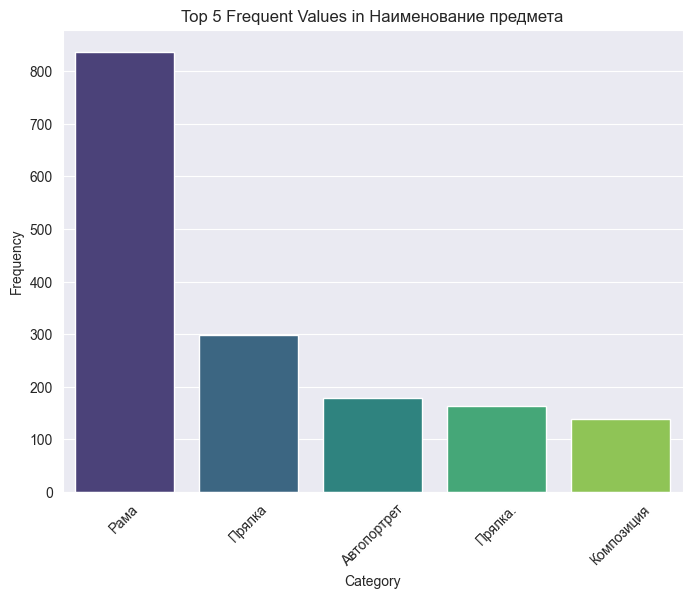

Автор


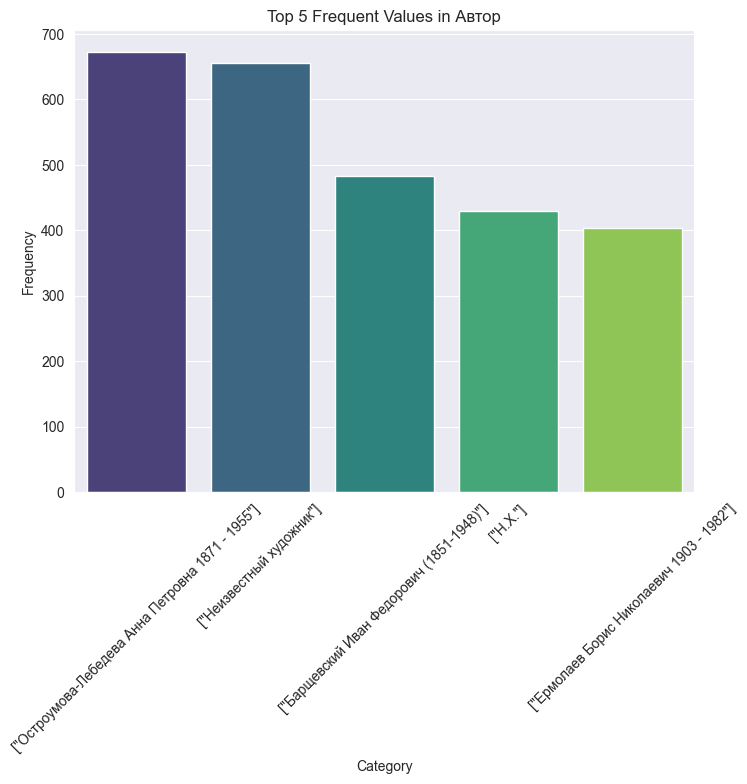

Музей


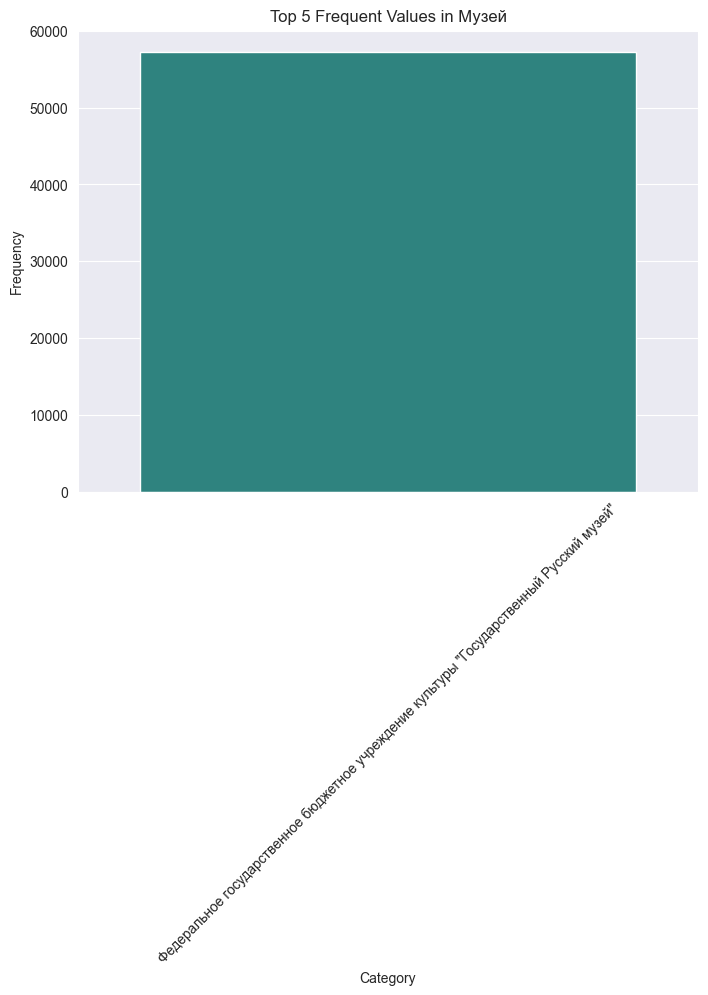

Items


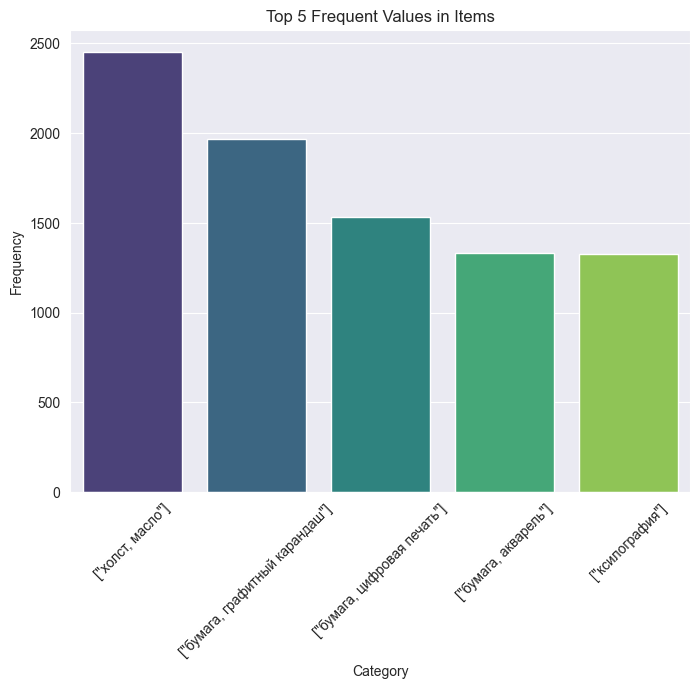

Дата создания предмета (строка)


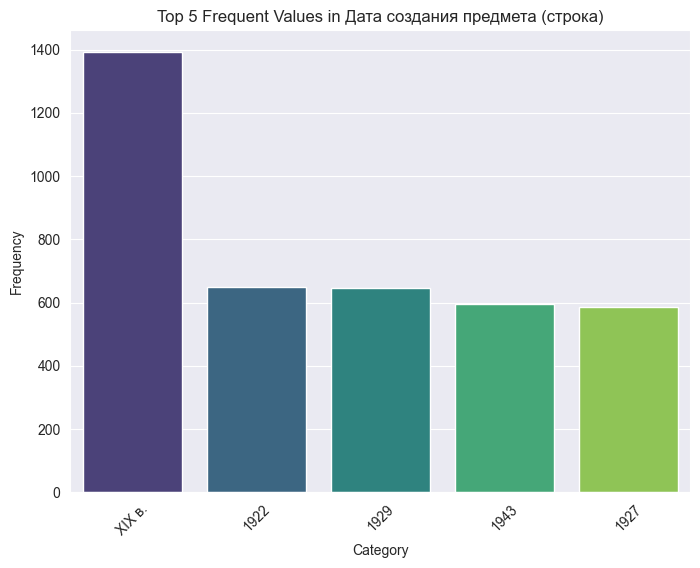

Место создания


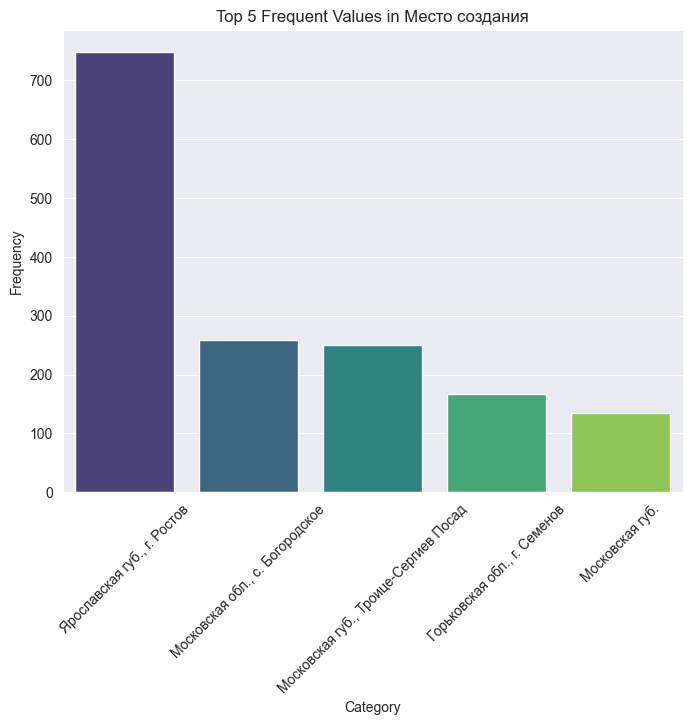

Строковое описание размеров


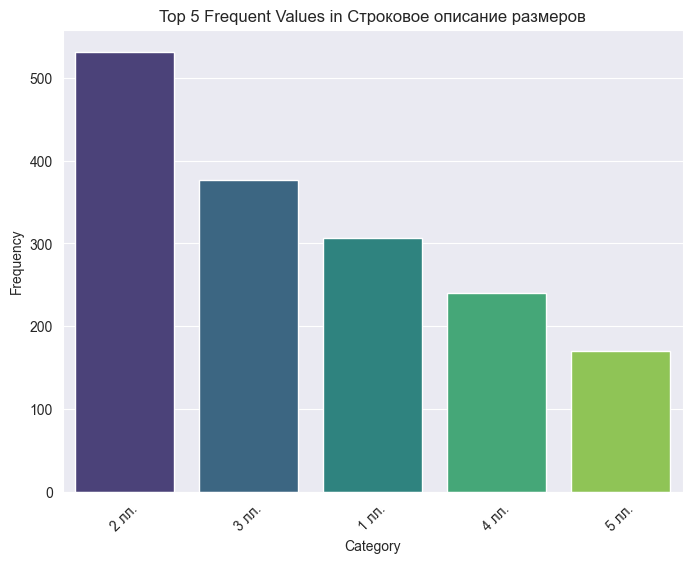

Описание


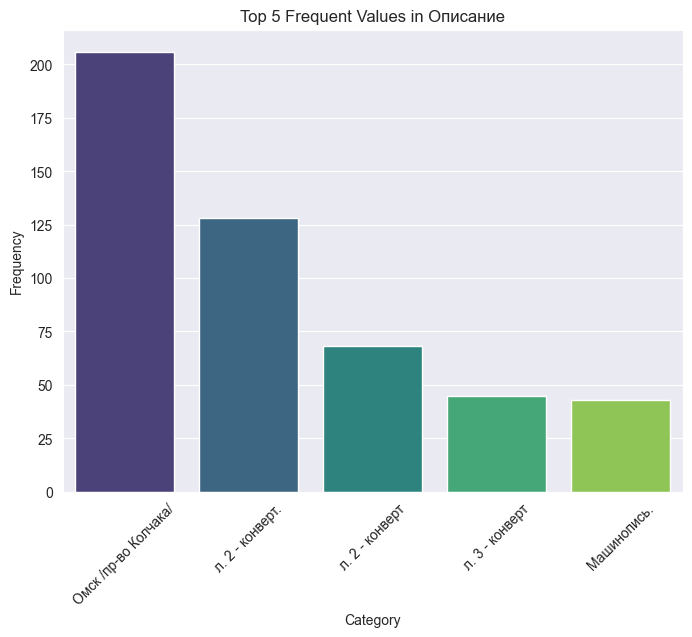

Количество составляющих
Изображение


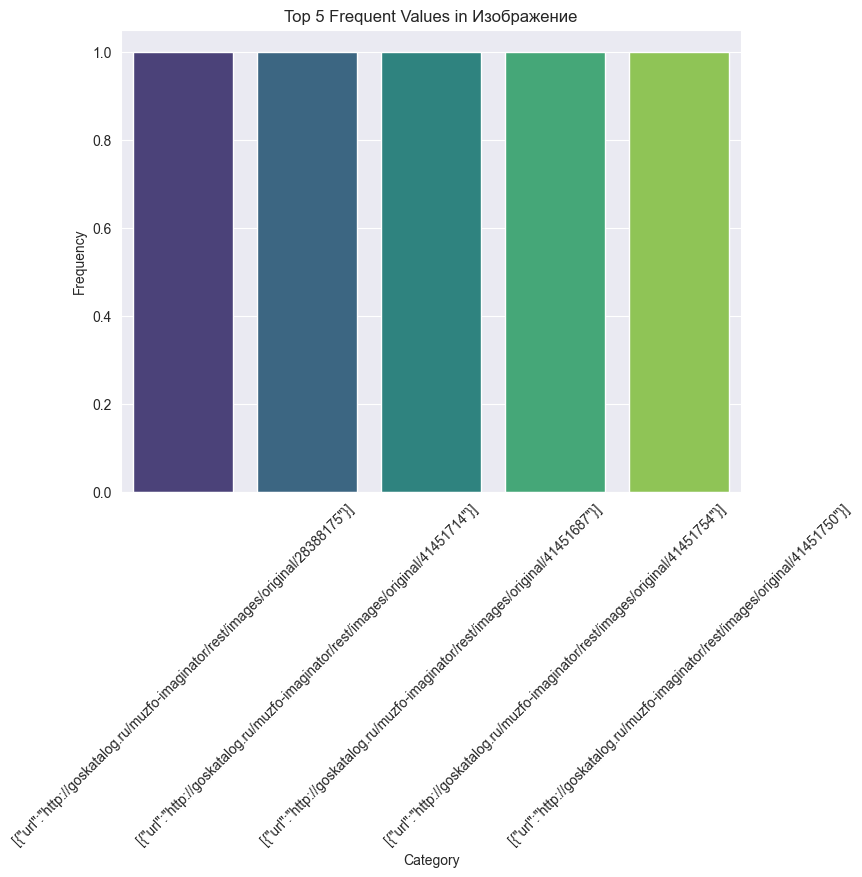

Регистрационный номер Госкаталога
Дата регистрации записи.


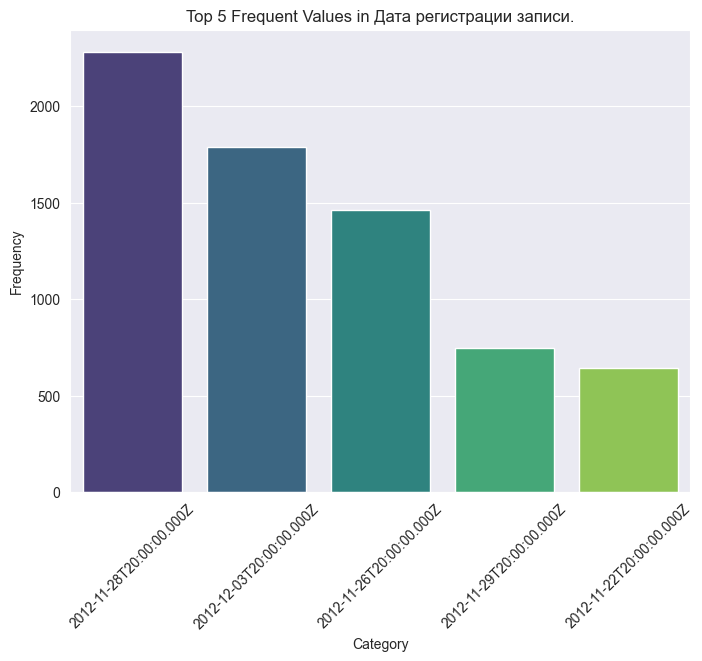

Инвентарный номер


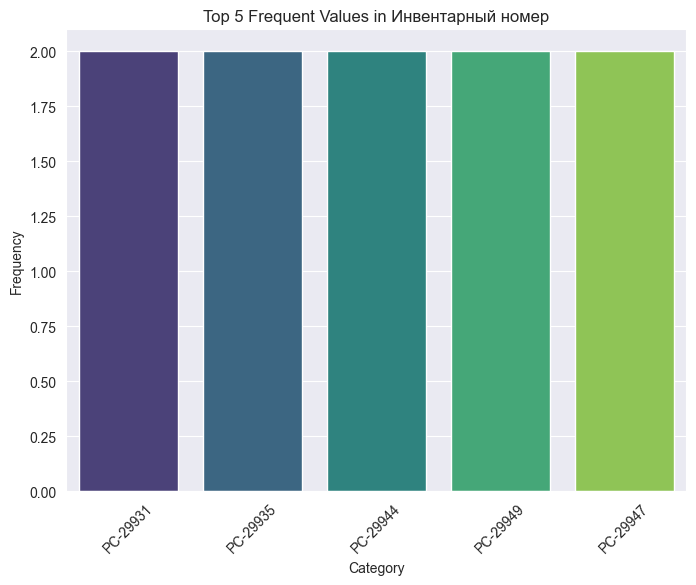

Номер по ГИК


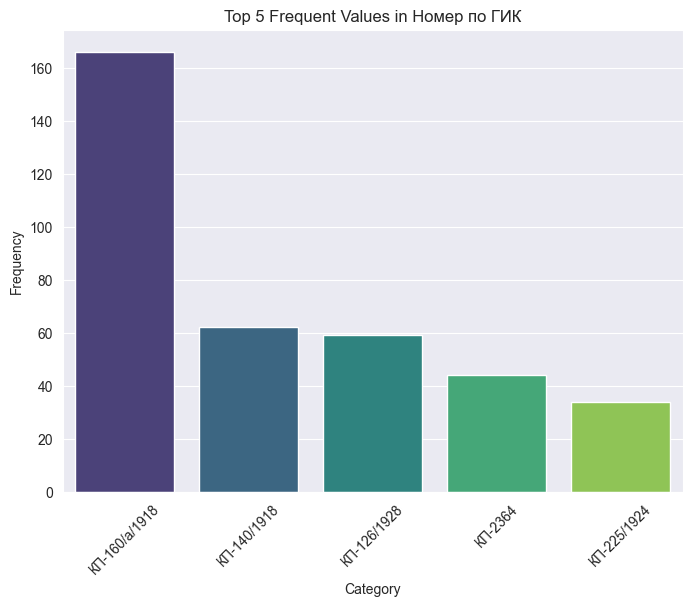

Ширина
Высота
Длина
Единица измерения размера


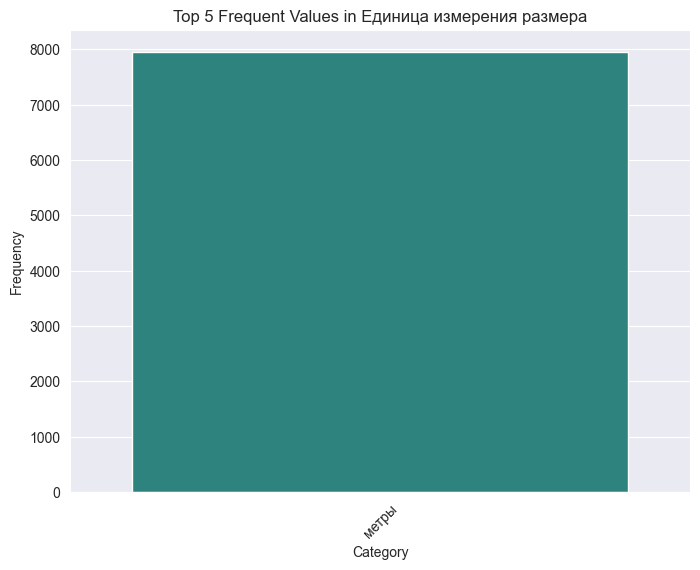

Интервал времени создания предмета (начало)


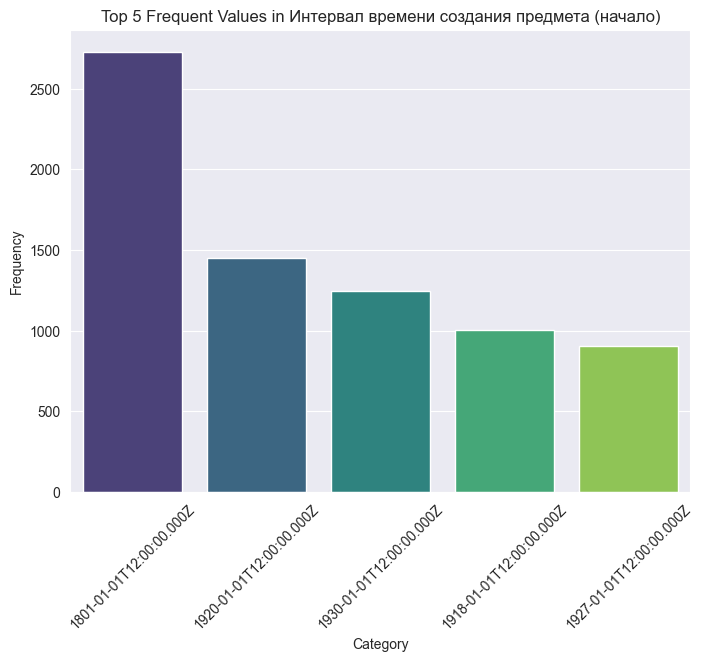

Интервал времени создания предмета (окончание)


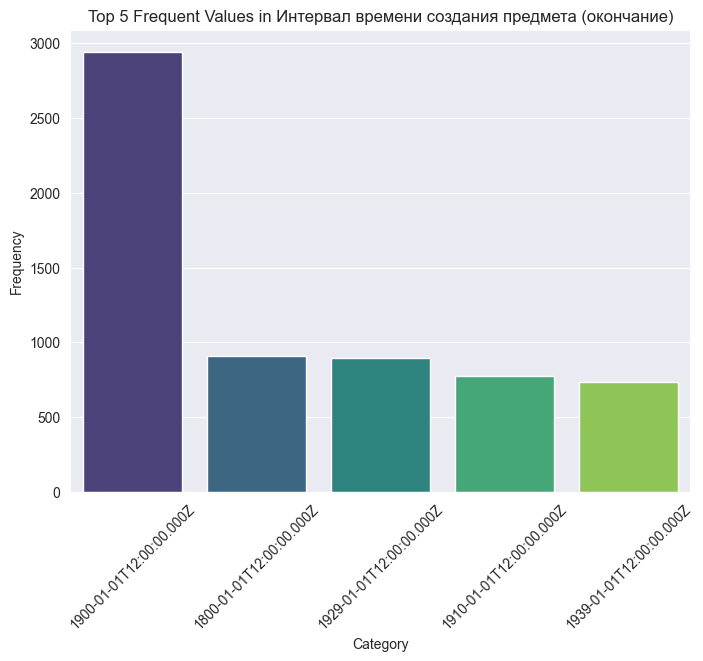

Точность задания времени (день, месяц, год, век, эпоха).


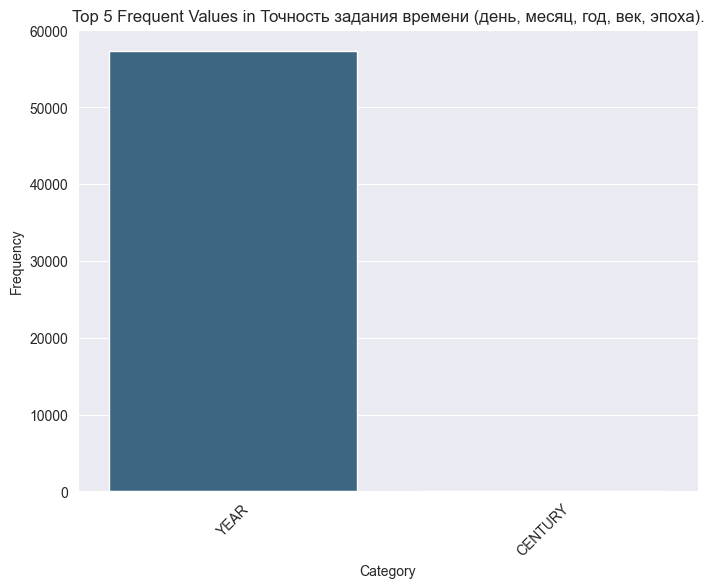

URL предмета на сайте музея


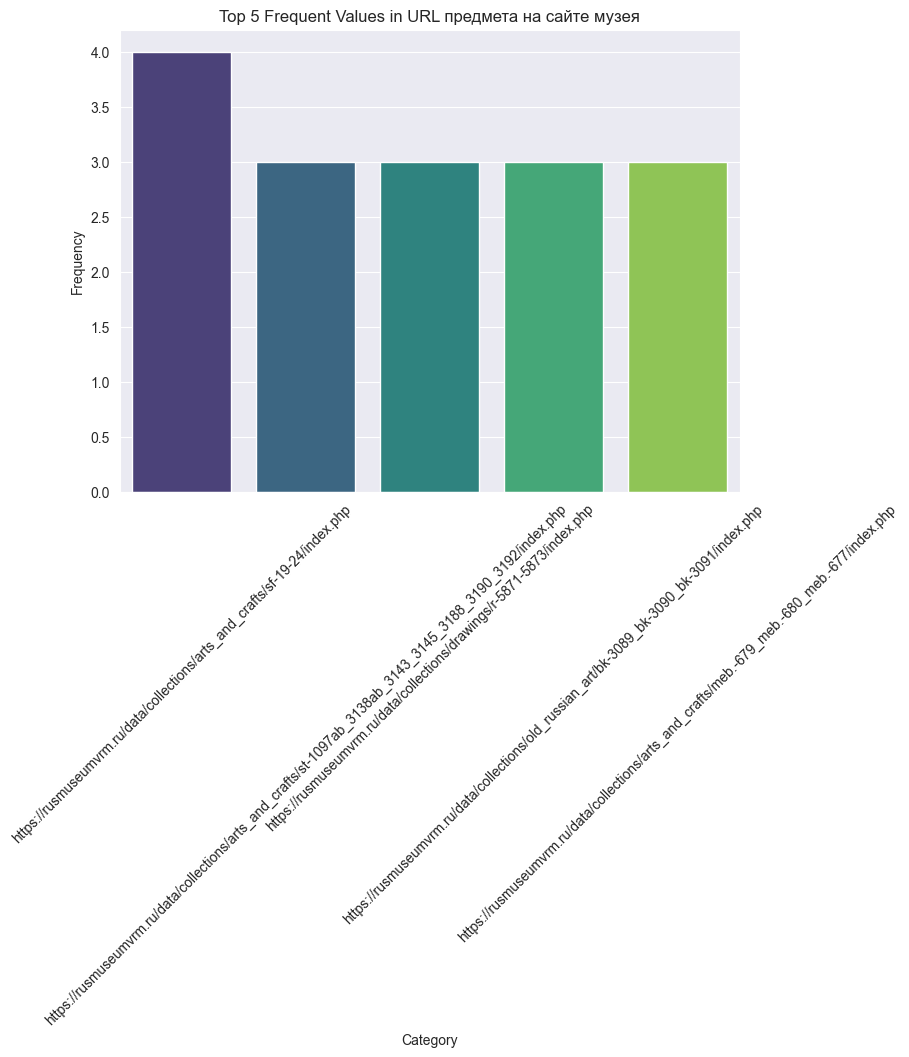

Ключевые слова
Краткое описание истории бытования (провенанс) предмета
Идентификатор статуса предмета
Типология


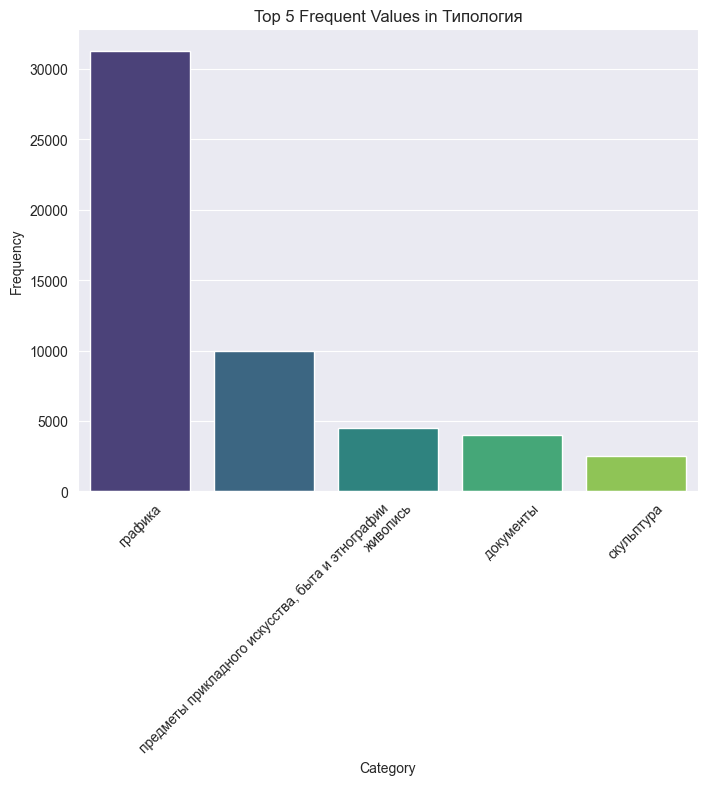

Фамилия


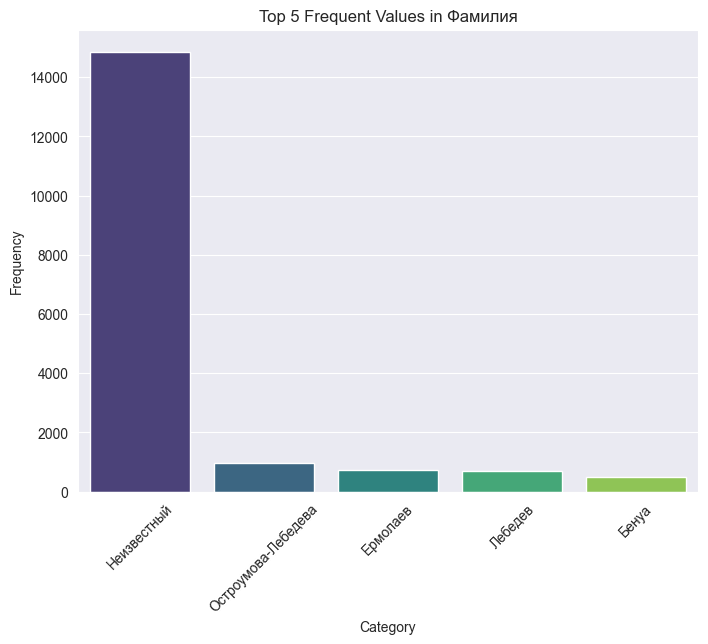

In [13]:
 for column in data_cleaned.columns:
    print(column)
    if data[column].dtype == 'object' or data[column].dtype.name == 'category':
        # Получаем топ-5 частых значений для каждого категориального признака
        top_5 = data_cleaned[column].value_counts().head(5)
        get_graph(top_5, column)


In [14]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57254 entries, 0 to 57253
Data columns (total 27 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Наименование предмета                                     57254 non-null  object 
 1   Автор                                                     44004 non-null  object 
 2   Музей                                                     57254 non-null  object 
 3   Items                                                     54817 non-null  object 
 4   Дата создания предмета (строка)                           55223 non-null  object 
 5   Место создания                                            6178 non-null   object 
 6   Строковое описание размеров                               57248 non-null  object 
 7   Описание                                                  57254 non-null  object 
 8   Количество соста

In [15]:
# Исключаем неинформативные признаки
cols_for_drop = ['Музей', 'Строковое описание размеров', 'Количество составляющих', 'Инвентарный номер', 'Номер по ГИК',
                 'Ширина', 'Длина', 'Единица измерения размера', 'Место создания', 'Количество составляющих',
                 'Ключевые слова', 'URL предмета на сайте музея', 'Высота', 'Идентификатор статуса предмета',
                 'Краткое описание истории бытования (провенанс) предмета',
                 'Точность задания времени (день, месяц, год, век, эпоха).',
                 'Интервал времени создания предмета (начало)',
                 'Интервал времени создания предмета (окончание)',

                 ]
data_cleaned.drop(cols_for_drop, axis=1, inplace=True)

In [16]:
data_cleaned

,Наименование предмета,Автор,Items,Дата создания предмета (строка),Описание,Изображение,Регистрационный номер Госкаталога,Дата регистрации записи.,Типология,Фамилия
0,Декоративный мотив.,"[""Малевич Казимир Северинович 1879-1935""]","[""бумага, тушь""]",1908,В вертикальной прямоугольной рамке декоративны...,"[{""url"":""http://goskatalog.ru/muzfo-imaginator...",10479770.0,2018-01-31T12:54:54.729Z,графика,Малевич
1,Женский портрет в шляпе с пером. На обороте: Н...,"[""Малевич Казимир Северинович (1879-1935)""]","[""бумага, графитный карандаш, растушевка""]",Конец 1900-х,"Портрет женщины в шляпе с пером (фронтально, о...","[{""url"":""http://goskatalog.ru/muzfo-imaginator...",10479769.0,2018-01-31T12:54:54.729Z,графика,Малевич
2,Декоративные мотивы. Три виньетки,"[""Малевич Казимир Северинович (1879-1935)""]","[""бумага верже, тушь, перо""]",Ок. 1908 (?),Три виньетки. Слева: овальная виньетка с цвето...,"[{""url"":""http://goskatalog.ru/muzfo-imaginator...",10479768.0,2018-01-31T12:54:54.729Z,графика,Малевич
3,Два женских портрета.,"[""Малевич Казимир Северинович 1879-1935""]","[""бумага, черные чернила""]",Конец 1920-х - начало 1930-х,"Один под другим, в рамках: два женских портрет...","[{""url"":""http://goskatalog.ru/muzfo-imaginator...",10479767.0,2018-01-31T12:54:54.729Z,графика,Малевич
4,Женский портрет (погрудный).,"[""Малевич Казимир Северинович (1879-1935)""]","[""бумага, бумага цветная, тушь, гуашь, наклейка""]",Сер.-2-ая половина 1900-х (?),В круге: на фоне с цветочными узорами - поясн...,"[{""url"":""http://goskatalog.ru/muzfo-imaginator...",10479766.0,2018-01-31T12:54:54.729Z,графика,Малевич
...,...,...,...,...,...,...,...,...,...,...
57249,Портрет Анны Андреевны Ахматовой.,"[""Петров-Водкин Кузьма Сергеевич (1878-1939)""]","[""холст, масло""]",1922,"Ахматова изображена по плечи, с поворотом слег...","[{""url"":""http://goskatalog.ru/muzfo-imaginator...",9876002.0,2017-12-11T11:44:01.596Z,живопись,Петров-Водкин
57250,Зима.,"[""Павлов Семен Андреевич 1893 - 1941""]","[""холст, масло""]",1923,Городской пейзаж. На первом плане: справа руин...,"[{""url"":""http://goskatalog.ru/muzfo-imaginator...",9876001.0,2017-12-11T11:44:01.596Z,живопись,Павлов
57251,Лестница. Ленинский проспект,"[""Волков Владимир Петрович 1923-1987""]","[""холст, масло""]",1987,Абстрактная композиция состоящая из прямоуголь...,"[{""url"":""http://goskatalog.ru/muzfo-imaginator...",9876000.0,2017-12-11T11:44:01.596Z,живопись,Волков
57252,Без названия,"[""Добротворский Сергей Николаевич 1959-1997""]","[""холст на фанере, масло""]",Конец 1980-х гг.,В верхней части картины - летящий влево желты...,"[{""url"":""http://goskatalog.ru/muzfo-imaginator...",9875998.0,2017-12-11T11:44:01.596Z,живопись,Добротворский


In [17]:
data_cleaned.columns

Index(['Наименование предмета', 'Автор', 'Items',
       'Дата создания предмета (строка)', 'Описание', 'Изображение',
       'Регистрационный номер Госкаталога', 'Дата регистрации записи.',
       'Типология', 'Фамилия'],
      dtype='object')

In [18]:
# Переименовываем столбцы
data_cleaned = data_cleaned.rename(columns={
    'Наименование предмета': 'title',
    'Автор': 'author_full_name',
    'Фамилия': 'author',
    'Items': 'items',
    'Описание': 'description',
    'Изображение': 'image_url',
    'Регистрационный номер Госкаталога': 'catalog_num',
    'Дата регистрации записи.': 'registration_date',
    'Типология': 'typology',
    'Дата создания предмета (строка)': 'creation_date',

})

In [19]:
data_cleaned.columns

Index(['title', 'author_full_name', 'items', 'creation_date', 'description',
       'image_url', 'catalog_num', 'registration_date', 'typology', 'author'],
      dtype='object')

## Выбор графики и живописи

In [20]:
data_cleaned['typology'].value_counts()

typology
графика                                              31225
предметы прикладного искусства, быта и этнографии     9973
живопись                                              4482
документы                                             4033
скульптура                                            2493
предметы нумизматики                                  2175
прочие                                                1934
фотографии и негативы                                  939
Name: count, dtype: int64

In [21]:
# Приводим столбец 'Типология' к нижнему регистру и удаляем лишние пробелы
data_cleaned['typology'] = data_cleaned['typology'].str.strip().str.lower()

# Выбираем строки с типологией 'графика' или 'живопись'
picture_data = data_cleaned[data_cleaned['typology'].isin(['графика', 'живопись'])].reset_index(drop=True)

In [22]:
picture_data

,title,author_full_name,items,creation_date,description,image_url,catalog_num,registration_date,typology,author
0,Декоративный мотив.,"[""Малевич Казимир Северинович 1879-1935""]","[""бумага, тушь""]",1908,В вертикальной прямоугольной рамке декоративны...,"[{""url"":""http://goskatalog.ru/muzfo-imaginator...",10479770.0,2018-01-31T12:54:54.729Z,графика,Малевич
1,Женский портрет в шляпе с пером. На обороте: Н...,"[""Малевич Казимир Северинович (1879-1935)""]","[""бумага, графитный карандаш, растушевка""]",Конец 1900-х,"Портрет женщины в шляпе с пером (фронтально, о...","[{""url"":""http://goskatalog.ru/muzfo-imaginator...",10479769.0,2018-01-31T12:54:54.729Z,графика,Малевич
2,Декоративные мотивы. Три виньетки,"[""Малевич Казимир Северинович (1879-1935)""]","[""бумага верже, тушь, перо""]",Ок. 1908 (?),Три виньетки. Слева: овальная виньетка с цвето...,"[{""url"":""http://goskatalog.ru/muzfo-imaginator...",10479768.0,2018-01-31T12:54:54.729Z,графика,Малевич
3,Два женских портрета.,"[""Малевич Казимир Северинович 1879-1935""]","[""бумага, черные чернила""]",Конец 1920-х - начало 1930-х,"Один под другим, в рамках: два женских портрет...","[{""url"":""http://goskatalog.ru/muzfo-imaginator...",10479767.0,2018-01-31T12:54:54.729Z,графика,Малевич
4,Женский портрет (погрудный).,"[""Малевич Казимир Северинович (1879-1935)""]","[""бумага, бумага цветная, тушь, гуашь, наклейка""]",Сер.-2-ая половина 1900-х (?),В круге: на фоне с цветочными узорами - поясн...,"[{""url"":""http://goskatalog.ru/muzfo-imaginator...",10479766.0,2018-01-31T12:54:54.729Z,графика,Малевич
...,...,...,...,...,...,...,...,...,...,...
35702,Портрет Анны Андреевны Ахматовой.,"[""Петров-Водкин Кузьма Сергеевич (1878-1939)""]","[""холст, масло""]",1922,"Ахматова изображена по плечи, с поворотом слег...","[{""url"":""http://goskatalog.ru/muzfo-imaginator...",9876002.0,2017-12-11T11:44:01.596Z,живопись,Петров-Водкин
35703,Зима.,"[""Павлов Семен Андреевич 1893 - 1941""]","[""холст, масло""]",1923,Городской пейзаж. На первом плане: справа руин...,"[{""url"":""http://goskatalog.ru/muzfo-imaginator...",9876001.0,2017-12-11T11:44:01.596Z,живопись,Павлов
35704,Лестница. Ленинский проспект,"[""Волков Владимир Петрович 1923-1987""]","[""холст, масло""]",1987,Абстрактная композиция состоящая из прямоуголь...,"[{""url"":""http://goskatalog.ru/muzfo-imaginator...",9876000.0,2017-12-11T11:44:01.596Z,живопись,Волков
35705,Без названия,"[""Добротворский Сергей Николаевич 1959-1997""]","[""холст на фанере, масло""]",Конец 1980-х гг.,В верхней части картины - летящий влево желты...,"[{""url"":""http://goskatalog.ru/muzfo-imaginator...",9875998.0,2017-12-11T11:44:01.596Z,живопись,Добротворский


In [23]:
# Выбор данных, которые не относятся к 'графика' и 'живопись'
other_data = data_cleaned[~data_cleaned['typology'].isin(['графика', 'живопись'])]
other_data.to_csv(f'{df_path}/other_data.csv', index=False)

## Очистка столбца Материалы

In [24]:
picture_data['items'] = picture_data['items'].str.replace('["', '').str.replace('"]', '')

In [25]:
picture_data['items']

0                                         бумага, тушь
1               бумага, графитный карандаш, растушевка
2                             бумага верже, тушь, перо
3                               бумага, черные чернила
4        бумага, бумага цветная, тушь, гуашь, наклейка
                             ...                      
35702                                     холст, масло
35703                                     холст, масло
35704                                     холст, масло
35705                           холст на фанере, масло
35706                                     холст, масло
Name: items, Length: 35707, dtype: object

In [26]:
synonyms = {
    r'^графитный карандаш$': 'карандаш',
    r'^цветной карандаш$': 'карандаш',
    r'^карандаш графитовый$': 'карандаш',
    r'^карандаш графитный$': 'карандаш',
    r'^цифровая печать$': 'печать',
    r'^типографская печать$': 'печать',
    r'^альбуминовая печать$': 'печать',
    r'^лит$': 'литография',
    r'^литография с тоном$': 'литография',
    r'^литография цветная$': 'литография',
    r'^бумага верже$': 'бумага',
    r'^роспись полихромная$': 'роспись',
    r'^б.$': 'бумага',
    r'^черные чернила$': 'тушь',
    r'^акв$': 'акварель',
    r'^акв\.$': 'акварель',
    r'^гравюра пунктиром$': 'гравюра',
    r'^гравюра на дереве$': 'гравюра',
    r'^карандаш итальянский$': 'карандаш',
    r'^гравюра резцом$': 'гравюра',
    r'^бумага на картоне$': 'бумага',
    r'^бумага серая$': 'бумага',
    r'^черный карандаш$': 'карандаш',
    r'^граф\. кар\.$': 'карандаш',
    r'^карандаши цветные$': 'карандаш',
    r'^карандаш черный$': 'карандаш',
    r'^акварель черная$': 'акварель',
    r'^линогравюра$': 'гравюра',
    r'^шариковая ручка$': 'чернила',
    r'^хромолитография$': 'литография',
    r'^автолитография$': 'литография',
    r'^литография раскрашенная$': 'литография',
    r'^фанера$': 'дерево',
    r'^акварельарель черная$': 'акварель',
    r'^цветная литография$': 'литография',
    r'^граф\. кар$': 'карандаш',
    r'^холст на картоне$': 'холст',
    r'^карандаш угольный$': 'карандаш',
    r'^бумага цветная$': 'бумага',
    r'^бумага желтая$': 'бумага',
    r'^бумага черная$': 'бумага',
    r'^черная акварель$': 'акварель',
    r'^акварель атинта$': 'акварель',
    r'^\\nмасло$': 'масло',
    r'^гравюра цветная$': 'гравюра',
    r'^итальянский карандаш$': 'карандаш',
    r'^гравюра раскрашенная$': 'гравюра',
    r'^монотипия цветная$': 'монотипия',
    r'^уголь прессованный$': 'уголь',
    r'^граф\.кар\.$': 'картон',
    r'^бумага желтоватая$': 'бумага',
    r'^бумага коричневая$': 'бумага',
    r'^цветные карандаши$': 'карандаш',
    r'^карандаш свинцовый$': 'карандаш',
    r'^холст,масло$': 'масло',
    r'^масляная пастель$': 'пастель',
    r'^наклеенная на белую бумагу$': 'аппликация',
    r'^наклейки$': 'аппликация',
    r'^бумага мелованная$': 'бумага',
    r'^ксилография цветная$': 'ксилография',
    r'^карандаш литографский$': 'литография',
    r'^тушь цветная$': 'тушь',
    r'^мягкий лак$': 'лак',
    r'^гравюра на картоне$': 'гравюра',
    r'^картон мелованный$': 'картон',
    r'^бронзовая краска$': 'бронза',
    r'^к\.$': 'картон',
    r'^бумага голубая$': 'бумага',
    r'^бумага оберточная$': 'бумага',
    r'^слоновая кость\\nминиатюра$': 'миниатюра',
    r'^автолитография цветная$': 'литография',
    r'^гравюра резцом раскрашенная$': 'гравюра',
    r'^линогравюра цветная$': 'гравюра',
    r'^черн. акв$': 'акварель',
    r'^холст,\\nмасло$': 'масло',
    r'^цв. кар$': 'картон',
    r'^бумага зеленая$': 'бумага'

}


In [27]:
def clean_material(material, synonyms):
    if pd.isna(material):
        material = ''
    else:
        material = material.strip().lower()
    for old, new in synonyms.items():
        material = re.sub(old, new, material)
    return material

In [28]:
def analyze_top_materials(dataframe, column_name, synonyms, top_n=50):
    all_materials = dataframe[column_name].str.split(', ').explode()
    all_materials_cleaned = all_materials.progress_apply(lambda material: clean_material(material, synonyms))
    material_counts = Counter(all_materials_cleaned)
    counter = pd.DataFrame.from_dict(material_counts, orient='index', columns=['Count'])
    counter_cleaned = counter.sort_values(by='Count', ascending=False)
    top_materials = counter_cleaned.head(top_n)

    return top_materials.index.tolist()


In [29]:
top_50 = analyze_top_materials(picture_data, 'items', synonyms)
top_50

Processing rows...: 100%|██████████████████████████████████| 74848/74848 [00:06<00:00, 11399.07it/s]


['бумага',
 'карандаш',
 'акварель',
 'тушь',
 'масло',
 'литография',
 'холст',
 'гуашь',
 'перо',
 'гравюра',
 'уголь',
 'ксилография',
 'графит',
 'белила',
 'картон',
 'темпера',
 'офорт',
 'пастель',
 'сепия',
 'чернила',
 'кисть',
 'дерево',
 'сангина',
 'калька',
 'хромолит',
 'аппликация',
 'фломастер',
 'оргалит',
 'бронза',
 'лак',
 'коллаж',
 'монотипия',
 'акрил',
 'растушка',
 'соус',
 'процарапывание',
 'смешанная техника',
 'акватинта',
 'цинкография',
 'мел',
 'серебро',
 'сухая игла',
 'бистр',
 'ламповая копоть',
 'левкас',
 'миниатюра',
 'золотая краска',
 'клеевая краска',
 'типографский оттиск',
 'живопись яичными красками']

In [30]:
# Функция для обработки строки
def process_items(item):
    if pd.isna(item):
        return ''
    # Разделяем строку на отдельные материалы
    materials = item.split(', ')
    # Заменяем синонимы
    materials = [material for material in materials if material in top_50]
    # Удаляем дубликаты и сортируем
    return ','.join(sorted(set(materials)))

In [31]:
# Преобразуем столбец items в key_words
picture_data['key_materials'] = picture_data['items'].progress_apply(process_items)

Processing rows...: 100%|█████████████████████████████████| 35707/35707 [00:00<00:00, 134546.27it/s]


In [32]:
picture_data['key_materials']

0              бумага,тушь
1                   бумага
2                перо,тушь
3                   бумага
4        бумага,гуашь,тушь
               ...        
35702          масло,холст
35703          масло,холст
35704          масло,холст
35705                масло
35706          масло,холст
Name: key_materials, Length: 35707, dtype: object

In [33]:
picture_data.to_csv(f'{df_path}/picture_data_with_key_material.csv', index=False, encoding='utf-8', sep=';')

## Очистка столбца с датами

In [34]:
# функция для предобработки дат
def process_date(date_str):
    try:
        # Проверка на NaN
        if pd.isna(date_str):
            return "Неизвестно"

        # Преобразуем строку
        date_str = re.sub(r"[^\w\s\-]", "", date_str).lower()
        date_str = date_str.replace("х", "х годов")

        # Обработка "конец" (например, "конец 1920-х" или "конец 1900-х")
        if "конец" in date_str:
            decades = re.findall(r"\d{3,4}", date_str)
            if len(decades) == 1:
                start = int(decades[0])
                if start % 100 != 0:
                    return f"{start + 6}-{start + 9}"  # для конца десятилетия, например, конец 1920-х -> 1926-1929
                else:
                    return f"{start + 96}-{start + 99}"  # для конца десятилетия после 1900-х, например, конец 1900-х -> 1996-1999
            elif len(decades) == 2:
                return f"{decades[0]}-{decades[1]}"

        # Обработка "начало" (например, "начало 1920-х")
        if "начало" in date_str:
            decades = re.findall(r"\d{3,4}", date_str)
            if len(decades) == 1:
                start = int(decades[0])
                return f"{start}-{start + 9}"  # для начала десятилетия, например, начало 1920-х -> 1920-1929
            elif len(decades) == 2:
                return f"{decades[0]}-{decades[1]}"

        # Обработка "середина" (например, "середина 1920-х")
        if "середина" in date_str:
            decades = re.findall(r"\d{3,4}", date_str)
            if len(decades) == 1:
                start = int(decades[0])
                return f"{start + 4}-{start + 5}"

        # Обработка "1-я половина" и "2-я половина"
        if "1-я половина" in date_str or "1-ая половина" in date_str:
            decades = re.findall(r"\d{3,4}", date_str)
            if len(decades) == 1:
                start = int(decades[0])
                return f"{start}-{start + 49}"

        if "2-я половина" in date_str or "2-ая половина" in date_str:
            decades = re.findall(r"\d{3,4}", date_str)
            if len(decades) == 1:
                start = int(decades[0])
                return f"{start + 50}-{start + 99}"

        # Обработка диапазонов
        if "-" in date_str:
            years = re.findall(r"\d{4}", date_str)
            if len(years) == 2:
                start_year = int(years[0])
                end_year = int(years[1])
                if start_year >= 1000 and end_year <= 3000:
                    return f"{start_year}-{end_year}"
            elif len(years) == 1:
                return f"{years[0]}"

        # Обработка "около"
        if "ок" in date_str or "примерно" in date_str:
            years = re.findall(r"\d{4}", date_str)
            if len(years) == 1:
                return years[0]

        # Обработка одиночных годов
        years = re.findall(r"\d{4}", date_str)
        if len(years) == 1:
            return years[0]
        # Если ничего не найдено
        return "Неизвестно"
    except:
        return "Ошибка"


In [35]:
# Обработка всех строк
picture_data['date_cleaned'] = picture_data['creation_date'].progress_apply(process_date)
picture_data[['date_cleaned', 'creation_date']]

Processing rows...: 100%|█████████████████████████████████| 35707/35707 [00:00<00:00, 122005.39it/s]


,date_cleaned,creation_date
0,1908,1908
1,1996-1999,Конец 1900-х
2,1908,Ок. 1908 (?)
3,1920-1930,Конец 1920-х - начало 1930-х
4,1950-1999,Сер.-2-ая половина 1900-х (?)
...,...,...
35702,1922,1922
35703,1923,1923
35704,1987,1987
35705,1986-1989,Конец 1980-х гг.


In [36]:
def categorize_date(date_str):
    try:
        # Проверка на NaN и ошибки
        if pd.isna(date_str) or date_str == "Неизвестно":
            return "Неизвестно"

        # Обработка диапазонов (например, 1920-1930)
        if "-" in date_str:
            years = re.findall(r"\d{4}", date_str)
            if len(years) == 2:
                start_year = int(years[0])
                end_year = int(years[1])
                avg_year = (start_year + end_year) // 2
            else:
                return "Неизвестно"
        else:
            avg_year = int(date_str)

        # Определяем век на основе среднего года
        century = (avg_year // 100) + 1

        # Определяем, первая или вторая половина века
        if avg_year % 100 <= 50:
            return f"1-я пол.{century}"
        else:
            return f"2-я пол.{century}"

    except:
        return f"Ошибка"

In [37]:
picture_data['date_category'] = picture_data['date_cleaned'].progress_apply(categorize_date)
picture_data[['date_category', 'date_cleaned', 'creation_date']]

Processing rows...: 100%|█████████████████████████████████| 35707/35707 [00:00<00:00, 256464.90it/s]


,date_category,date_cleaned,creation_date
0,1-я пол.20,1908,1908
1,2-я пол.20,1996-1999,Конец 1900-х
2,1-я пол.20,1908,Ок. 1908 (?)
3,1-я пол.20,1920-1930,Конец 1920-х - начало 1930-х
4,2-я пол.20,1950-1999,Сер.-2-ая половина 1900-х (?)
...,...,...,...
35702,1-я пол.20,1922,1922
35703,1-я пол.20,1923,1923
35704,2-я пол.20,1987,1987
35705,2-я пол.20,1986-1989,Конец 1980-х гг.


In [38]:
picture_data.to_csv(f'{df_path}/picture_data_with_date_and_materials.csv', sep=';', encoding='utf-8', index=False)

# Поиск ключевых слов по названию и описанию

In [14]:
import spacy
from tqdm.notebook import tqdm
from spacy.lang.ru.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer

In [15]:
!python -m spacy download ru_core_news_sm


[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip



     ---------------------------------------- 0.0/15.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/15.3 MB ? eta -:--:--
     ---------------------------------------- 0.1/15.3 MB 1.7 MB/s eta 0:00:10
      --------------------------------------- 0.2/15.3 MB 2.1 MB/s eta 0:00:08
      --------------------------------------- 0.4/15.3 MB 2.2 MB/s eta 0:00:07
     - -------------------------------------- 0.5/15.3 MB 2.2 MB/s eta 0:00:07
     - -------------------------------------- 0.7/15.3 MB 3.0 MB/s eta 0:00:05
     --- ------------------------------------ 1.3/15.3 MB 4.2 MB/s eta 0:00:04
     ---- ----------------------------------- 1.6/15.3 MB 5.0 MB/s eta 0:00:03
     ----- ---------------------------------- 2.0/15.3 MB 5.4 MB/s eta 0:00:03
     ------ --------------------------------- 2.5/15.3 MB 6.2 MB/s eta 0:00:03
     ------- -------------------------------- 3.0/15.3 MB 6.6 MB/s eta 0:00:02
     -------- ------------------------------- 3.3/15.3 MB 6.9 MB/

In [16]:
# Загрузка модели spacy для русского языка
nlp = spacy.load("ru_core_news_sm")

In [17]:
# Функция для лемматизации и очистки текста
def lemmatize_text_spacy(text):
    doc = nlp(text.lower())  # Приводим к нижнему регистру
    lemmatized_words = [
        token.lemma_ for token in doc
        if token.is_alpha  # Убираем числа и знаки препинания
        and len(token.lemma_) > 1  # Исключаем отдельные буквы
        and token.lemma_ not in STOP_WORDS  # Исключаем стоп-слова
    ]
    return ' '.join(lemmatized_words)

In [18]:
def extract_keywords_with_tfidf(df, top_n=15):
    # Объединяем описание и название в единый текст и лемматизируем
    df['combined_text'] = df['description'] + ' ' + df['title']
    df['lemmatized_text'] = df['combined_text'].apply(lemmatize_text_spacy)

    # Инициализируем TF-IDF векторизатор с русскими стоп-словами
    vectorizer = TfidfVectorizer(stop_words=list(STOP_WORDS))
    tfidf_matrix = vectorizer.fit_transform(df['lemmatized_text'])
    feature_names = vectorizer.get_feature_names_out()

    df['key_words'] = ''

    for index in tqdm(range(len(df)), total=len(df), desc="Processing rows", ncols=100):
        # Получаем TF-IDF веса для текущей строки
        tfidf_vector = tfidf_matrix[index].toarray().flatten()
        top_indices = tfidf_vector.argsort()[-top_n:][::-1]

        # Извлекаем ключевые слова
        key_words = [feature_names[i] for i in top_indices if tfidf_vector[i] > 0]

        # Сохраняем ключевые слова
        df.at[index, 'key_words'] = ','.join(key_words)

    # Удаляем временные колонки
    df.drop(columns=['combined_text', 'lemmatized_text'], inplace=True)

    return df

In [44]:
df = extract_keywords_with_tfidf(picture_data)

Processing rows:   0%|                                                    | 0/35707 [00:00<?, ?it/s]

In [45]:
# Сохранение результата в CSV файл
df.to_csv(f'{df_path}/picture_data_with_keywords.csv', index=False, sep=';', encoding='utf-8')

In [46]:
df[['key_words', 'title', 'description']]

,key_words,title,description
0,"мотив,декоративный,нанизанными,стержень,диск,ц...",Декоративный мотив.,В вертикальной прямоугольной рамке декоративны...
1,"младенец,оборот,шляпа,женщина,портрет,пером,пе...",Женский портрет в шляпе с пером. На обороте: Н...,"Портрет женщины в шляпе с пером (фронтально, о..."
2,"виньетка,прямоугольный,три,стеблями,рамка,симм...",Декоративные мотивы. Три виньетки,Три виньетки. Слева: овальная виньетка с цвето...
3,"изображенной,недлинный,распущенные,платье,женс...",Два женских портрета.,"Один под другим, в рамках: два женских портрет..."
4,"круг,крапинка,вставка,цветочный,картон,портрет...",Женский портрет (погрудный).,В круге: на фоне с цветочными узорами - поясн...
...,...,...,...
35702,"ахматов,синий,склоненной,подстричь,горбинка,ан...",Портрет Анны Андреевны Ахматовой.,"Ахматова изображена по плечи, с поворотом слег..."
35703,"дом,серый,полуразрушенные,разбитый,кирпичный,р...",Зима.,Городской пейзаж. На первом плане: справа руин...
35704,"ленинский,овала,проспект,напоминать,цветной,со...",Лестница. Ленинский проспект,Абстрактная композиция состоящая из прямоуголь...
35705,"расклешенной,планета,картина,парить,воздух,кра...",Без названия,В верхней части картины - летящий влево желты...


# Сохранение датафрейма для кластеризации и загрузка в бд

In [47]:
df.drop(['date_cleaned', 'key_materials', 'creation_date'], inplace=True, axis=1)

In [48]:
columns_for_db = [
    'image_url', 'catalog_num', 'registration_date',
]

In [49]:
def reformate_url(column):
    if pd.isna(column):
        return None
    match = re.search(r'"url":"(http[s]?://[^"]+)"', column)
    if match:
        return match.group(1)
    return None

In [50]:
df['image_url'] = df['image_url'].apply(reformate_url)

In [51]:
df['image_url'].head()

0    http://goskatalog.ru/muzfo-imaginator/rest/ima...
1    http://goskatalog.ru/muzfo-imaginator/rest/ima...
2    http://goskatalog.ru/muzfo-imaginator/rest/ima...
3    http://goskatalog.ru/muzfo-imaginator/rest/ima...
4    http://goskatalog.ru/muzfo-imaginator/rest/ima...
Name: image_url, dtype: object

In [52]:
df.to_csv(f'{df_path}/data_for_database.csv', index=False, sep=';', encoding='utf-8')

In [53]:
df = pd.read_csv(f'{df_path}/data_for_database.csv', sep=';', encoding='utf-8')

In [54]:
df.drop(columns_for_db, inplace=True, axis=1)

In [55]:
df.columns

Index(['title', 'author_full_name', 'items', 'description', 'typology',
       'author', 'date_category', 'key_words'],
      dtype='object')

In [56]:
df.rename(columns={
    'author_lastname': 'author',
}, inplace=True)

In [57]:
df.to_csv(f'{df_path}/data_for_clasterisation.csv', index=False, sep=';', encoding='utf-8')

In [58]:
df

,title,author_full_name,items,description,typology,author,date_category,key_words
0,Декоративный мотив.,"[""Малевич Казимир Северинович 1879-1935""]","бумага, тушь",В вертикальной прямоугольной рамке декоративны...,графика,Малевич,1-я пол.20,"мотив,декоративный,нанизанными,стержень,диск,ц..."
1,Женский портрет в шляпе с пером. На обороте: Н...,"[""Малевич Казимир Северинович (1879-1935)""]","бумага, графитный карандаш, растушевка","Портрет женщины в шляпе с пером (фронтально, о...",графика,Малевич,2-я пол.20,"младенец,оборот,шляпа,женщина,портрет,пером,пе..."
2,Декоративные мотивы. Три виньетки,"[""Малевич Казимир Северинович (1879-1935)""]","бумага верже, тушь, перо",Три виньетки. Слева: овальная виньетка с цвето...,графика,Малевич,1-я пол.20,"виньетка,прямоугольный,три,стеблями,рамка,симм..."
3,Два женских портрета.,"[""Малевич Казимир Северинович 1879-1935""]","бумага, черные чернила","Один под другим, в рамках: два женских портрет...",графика,Малевич,1-я пол.20,"изображенной,недлинный,распущенные,платье,женс..."
4,Женский портрет (погрудный).,"[""Малевич Казимир Северинович (1879-1935)""]","бумага, бумага цветная, тушь, гуашь, наклейка",В круге: на фоне с цветочными узорами - поясн...,графика,Малевич,2-я пол.20,"круг,крапинка,вставка,цветочный,картон,портрет..."
...,...,...,...,...,...,...,...,...
35702,Портрет Анны Андреевны Ахматовой.,"[""Петров-Водкин Кузьма Сергеевич (1878-1939)""]","холст, масло","Ахматова изображена по плечи, с поворотом слег...",живопись,Петров-Водкин,1-я пол.20,"ахматов,синий,склоненной,подстричь,горбинка,ан..."
35703,Зима.,"[""Павлов Семен Андреевич 1893 - 1941""]","холст, масло",Городской пейзаж. На первом плане: справа руин...,живопись,Павлов,1-я пол.20,"дом,серый,полуразрушенные,разбитый,кирпичный,р..."
35704,Лестница. Ленинский проспект,"[""Волков Владимир Петрович 1923-1987""]","холст, масло",Абстрактная композиция состоящая из прямоуголь...,живопись,Волков,2-я пол.20,"ленинский,овала,проспект,напоминать,цветной,со..."
35705,Без названия,"[""Добротворский Сергей Николаевич 1959-1997""]","холст на фанере, масло",В верхней части картины - летящий влево желты...,живопись,Добротворский,2-я пол.20,"расклешенной,планета,картина,парить,воздух,кра..."


# Рекомендательная система

In [59]:
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from tqdm import tqdm
from transformers import BertTokenizer, BertModel


In [24]:
folder_path = './data-copy'
df_path = folder_path + '/data_for_clasterisation.csv'

In [61]:
# Инициализация tqdm_pandas
tqdm.pandas()

In [62]:
df = pd.read_csv(df_path, sep=';', encoding='utf-8')
df

,title,author_full_name,items,description,typology,author,date_category,key_words
0,Декоративный мотив.,"[""Малевич Казимир Северинович 1879-1935""]","бумага, тушь",В вертикальной прямоугольной рамке декоративны...,графика,Малевич,1-я пол.20,"мотив,декоративный,нанизанными,стержень,диск,ц..."
1,Женский портрет в шляпе с пером. На обороте: Н...,"[""Малевич Казимир Северинович (1879-1935)""]","бумага, графитный карандаш, растушевка","Портрет женщины в шляпе с пером (фронтально, о...",графика,Малевич,2-я пол.20,"младенец,оборот,шляпа,женщина,портрет,пером,пе..."
2,Декоративные мотивы. Три виньетки,"[""Малевич Казимир Северинович (1879-1935)""]","бумага верже, тушь, перо",Три виньетки. Слева: овальная виньетка с цвето...,графика,Малевич,1-я пол.20,"виньетка,прямоугольный,три,стеблями,рамка,симм..."
3,Два женских портрета.,"[""Малевич Казимир Северинович 1879-1935""]","бумага, черные чернила","Один под другим, в рамках: два женских портрет...",графика,Малевич,1-я пол.20,"изображенной,недлинный,распущенные,платье,женс..."
4,Женский портрет (погрудный).,"[""Малевич Казимир Северинович (1879-1935)""]","бумага, бумага цветная, тушь, гуашь, наклейка",В круге: на фоне с цветочными узорами - поясн...,графика,Малевич,2-я пол.20,"круг,крапинка,вставка,цветочный,картон,портрет..."
...,...,...,...,...,...,...,...,...
35702,Портрет Анны Андреевны Ахматовой.,"[""Петров-Водкин Кузьма Сергеевич (1878-1939)""]","холст, масло","Ахматова изображена по плечи, с поворотом слег...",живопись,Петров-Водкин,1-я пол.20,"ахматов,синий,склоненной,подстричь,горбинка,ан..."
35703,Зима.,"[""Павлов Семен Андреевич 1893 - 1941""]","холст, масло",Городской пейзаж. На первом плане: справа руин...,живопись,Павлов,1-я пол.20,"дом,серый,полуразрушенные,разбитый,кирпичный,р..."
35704,Лестница. Ленинский проспект,"[""Волков Владимир Петрович 1923-1987""]","холст, масло",Абстрактная композиция состоящая из прямоуголь...,живопись,Волков,2-я пол.20,"ленинский,овала,проспект,напоминать,цветной,со..."
35705,Без названия,"[""Добротворский Сергей Николаевич 1959-1997""]","холст на фанере, масло",В верхней части картины - летящий влево желты...,живопись,Добротворский,2-я пол.20,"расклешенной,планета,картина,парить,воздух,кра..."


In [63]:
# очистка пропусков
df['key_words'] = df['key_words'].fillna('')
df['author'] = df['author'].fillna('')
df['key_words'] = df['key_words'] + ',' + df['author']

## 2. Кодирование признаков

In [64]:
# Загрузка предобученной модели для русского языка
model_name = 'DeepPavlov/rubert-base-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [65]:
# Функция для получения эмбеддингов с помощью RuBERT
def get_embeddings(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings

In [66]:
def get_item_embeddings(data):
    descriptions = data['key_words'].tolist()
    embeddings = []
    # Получаем эмбеддинги для каждого экспоната
    for desc in tqdm(descriptions, desc="Генерация эмбеддингов для описаний", unit="экспонат"):
        embedding = get_embeddings([desc])
        embeddings.append(embedding)
    # Преобразуем список эмбеддингов в numpy массив
    embeddings = torch.cat(embeddings, dim=0).numpy()
    return embeddings

In [67]:
# Функция для дополнения эмбеддинга запроса до требуемой размерности
def resize_embedding(query_embedding, target_dim):
    current_dim = query_embedding.shape[1]

    # Если текущая размерность уже совпадает с целевой, возвращаем эмбеддинг без изменений
    if current_dim == target_dim:
        return query_embedding

    # Если текущая размерность меньше целевой, дополняем нулями
    if current_dim < target_dim:
        padding = np.zeros((query_embedding.shape[0], target_dim - current_dim))
        return np.hstack([query_embedding, padding])

    # Если текущая размерность больше целевой, обрезаем лишние элементы
    return query_embedding[:, :target_dim]


In [68]:
# Функция визуализации кластеров
def visualize_clusters(features, data, method="PCA"):
    # Снижение размерности
    if method == "PCA":
        reducer = PCA(n_components=2)
    elif method == "TSNE":
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
    else:
        raise ValueError("Метод должен быть 'PCA' или 'TSNE'")

    reduced_features = reducer.fit_transform(features)

    # Создание DataFrame для визуализации
    visualization_df = pd.DataFrame(reduced_features, columns=["Dim1", "Dim2"])
    visualization_df['cluster'] = data['cluster']

    # Визуализация кластеров
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x="Dim1", y="Dim2",
        hue="cluster",
        palette="tab10",
        data=visualization_df,
        legend="full"
    )
    plt.title(f"Визуализация кластеров ({method})", fontsize=16)
    plt.xlabel("Первая компонента", fontsize=12)
    plt.ylabel("Вторая компонента", fontsize=12)
    plt.legend(title="Кластеры")
    plt.show()


In [69]:
from sklearn.metrics import silhouette_score

def plot_silhouette_score(X, min_clusters=2, max_clusters=10):
    scores = []
    cluster_range = range(min_clusters, max_clusters + 1)

    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        scores.append(score)

    # Построение графика
    plt.figure(figsize=(8, 5))
    plt.plot(cluster_range, scores, marker='o', linestyle='--')
    plt.xlabel("Число кластеров")
    plt.ylabel("Силуэтный коэффициент")
    plt.title("Определение оптимального числа кластеров")
    plt.xticks(cluster_range)
    plt.grid(True)
    plt.show()

In [70]:
embeddings = get_item_embeddings(df)

Генерация эмбеддингов для описаний: 100%|██████████| 35707/35707 [54:52<00:00, 10.84экспонат/s]  


In [71]:
embeddings

array([[ 1.0375497 ,  0.06514211,  0.6857159 , ...,  1.3588467 ,
         0.15613349,  0.08646344],
       [ 0.44638625, -0.02925074,  0.72633857, ...,  1.3535382 ,
         0.3878968 , -0.1002064 ],
       [ 0.77163   ,  0.37287197,  0.28302962, ...,  0.7777483 ,
         0.34911284,  0.07042709],
       ...,
       [ 0.37501386,  0.00340225, -0.11268464, ...,  1.2501523 ,
         0.43707058,  0.10284408],
       [ 0.21951015, -0.20177473,  0.59045184, ...,  1.4071229 ,
         0.6580667 , -0.21406639],
       [ 0.37109882,  0.23302427,  0.57458454, ...,  1.2085218 ,
         0.3631543 , -0.56830484]], dtype=float32)

In [72]:
np.save(folder_path + '/embeddings.npy', embeddings)

In [73]:
# Сохранение в CSV
with open(folder_path + 'embeddings.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(embeddings)

In [38]:
embeddings = np.load('./data-copy/embeddings.npy')

In [74]:
embeddings.shape

(35707, 768)

In [75]:
!pip install pyarrow


[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [76]:
df['embeddings'] = list(embeddings)
# Сохраняем в Parquet (меньше места, быстрее загрузка)
df.to_parquet(folder_path + "/dataset_with_embeddings.parquet", index=False, engine="pyarrow")

In [77]:
df = pd.read_parquet(folder_path + "/dataset_with_embeddings.parquet")
df

,title,author_full_name,items,description,typology,author,date_category,key_words,embeddings
0,Декоративный мотив.,"[""Малевич Казимир Северинович 1879-1935""]","бумага, тушь",В вертикальной прямоугольной рамке декоративный мотив (центральная часть - в виде чёрного стержня с нанизанными на него дисками),графика,Малевич,1-я пол.20,"мотив,декоративный,нанизанными,стержень,диск,центральный,прямоугольный,вертикальный,рамка,чёрный,вид,часть,Малевич","[1.0375497, 0.06514211, 0.6857159, -0.11629645, -0.5514033, 1.0471567, -0.033659466, -0.7717726, 0.46907043, 0.6476442, -0.0062597925, 0.048025787, 0.4506426, 0.08214628, 0.096501514, -0.6963587, 0.47483462, 0.12824342, 0.40710723, 0.14754927, -0.26892316, 0.66398585, 0.06618212, 0.25025454, -0.09801163, -0.06287996, -1.2896776, -0.4990395, -0.30099693, -0.107096985, -0.011150629, 0.06091568, 0.6459023, -0.004164636, -0.44143844, 0.39752188, -0.04525373, -0.52683836, -0.293506, 0.95202494, -0.3880151, -0.050208554, 0.16577834, 0.2347445, 0.16343004, -0.30750886, 0.1921446, 0.370629, -0.6085293, -0.6587533, 0.3959642, 0.037651315, 0.3131981, -0.52652377, -0.47310227, -0.06551409, -0.49399728, -0.45614225, 0.48048723, 0.33525366, -0.18026128, -0.49397433, -0.40897185, 0.22188568, -0.71085167, 0.08599152, 0.15893023, -0.61558366, 0.57278067, 0.22088385, -1.1666098, 0.84117347, -0.6008721, -0.58954585, 0.18315369, 0.92709863, 0.42713654, 0.22434552, 0.45187214, -0.43246174, -0.25564602, -0.62885785, 0.7924565, 0.84808344, -0.45349783, -0.33550733, -0.0041214526, -0.9105722, 0.48174512, -1.3493668, -0.6096928, 0.2738434, 0.3039856, 0.5899973, -0.5460171, 0.5829893, 0.023837704, -0.17761345, -0.14451359, 0.47817618, ...]"
1,Женский портрет в шляпе с пером. На обороте: На обороте: Фигура женщины с младенцем на руках,"[""Малевич Казимир Северинович (1879-1935)""]","бумага, графитный карандаш, растушевка","Портрет женщины в шляпе с пером (фронтально, оплечно). Изображение очерчено. На обороте: На обороте: в левой части листа - стоящая женщина с младенцем на руках.",графика,Малевич,2-я пол.20,"младенец,оборот,шляпа,женщина,портрет,пером,перо,стоящий,оплечный,очертить,рука,фронтальный,женский,часть,фигура,Малевич","[0.44638625, -0.029250745, 0.72633857, -0.004611733, -0.58378524, 0.8726067, -0.2623831, -0.5404644, 0.5453443, 0.7943348, 0.022009322, 0.0018289341, 0.22833079, -0.15913744, -0.0029457305, -0.37102467, 0.3409244, 0.8638428, 0.16379297, 0.32429942, -0.30685988, 0.59966105, 0.14323899, -0.2812118, -0.008019773, 0.18463661, -0.84705925, -0.41504836, -0.2033122, -0.19481558, -0.15489359, 0.059856176, 0.8527961, 0.1722964, -0.7348584, 0.50429034, -0.28521582, -0.20086804, -0.33708715, 1.1803501, -1.0219655, -0.11240461, 0.3799199, 0.21626605, -0.079799294, -0.5184722, -0.050741524, 0.6051096, -0.44082993, -0.5437437, 0.4473888, 0.64925927, 0.15978414, -0.57966477, -0.2952095, -0.086345494, -0.6604851, -0.2918408, 0.6456003, 0.07255597, -0.011347466, 0.16052291, -0.1564795, 0.2737341, -0.68075186, 0.053057056, 0.21953723, -1.0769848, 0.26953843, -0.058846273, -0.8788946, 0.5062883, -0.17353766, -0.22032225, 0.37992433, 0.83899426, 0.5005892, 0.12865515, -0.0019412622, -0.5445053, -0.41157663, -0.3407469, -0.19889705, 0.39764562, -0.6949506, -0.4162581, -0.18212713, -0.9419582, 0.530304, -1.005687, -0.122467555, 0.7584758, 0.27674705, 0.50957096, -1.1474992, 0.27270338, -0.07654729, -0.2836301, -0.28600037, 0.10738637, ...]"
2,Декоративные мотивы. Три виньетки,"[""Малевич Казимир Северинович (1879-1935)""]","бумага верже, тушь, перо",Три виньетки. Слева: овальная виньетка с цветочным орнаментом. Справа внизу: виньетка в прямоугольной узкой рамке с двумя рядами симметрично расположенных цветов. Справа вверху: виньетка в прямоугольной рамке со стилизованным растением с тремя стеблями.,графика,Малевич,1-я пол.20,"виньетка,прямоугольный,три,стеблями,рамка,симметрично,цветочный,расположенных,растение,стилизованный,мотив,декоративный,овальный,узкий,орнамент,Малевич","[0.77163, 0.37287197, 0.283029

## Рекомендатлеьная система

In [82]:
embeddings = np.load(folder_path + '/embeddings.npy')

In [79]:
def create_kmeans_model(embeddings, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(embeddings)
    return kmeans

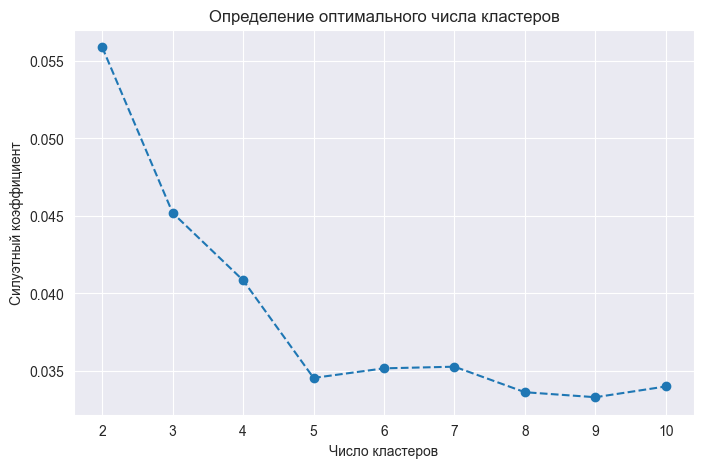

In [83]:
plot_silhouette_score(embeddings)

In [84]:
kmeans_model = create_kmeans_model(embeddings, n_clusters=5)
kmeans_model.cluster_centers_.shape

(5, 768)

In [26]:
from joblib import dump, load

In [85]:
# Сохранение модели
dump(kmeans_model, './data-copy/kmeans_model2.joblib')

['./data-copy/kmeans_model2.joblib']

In [27]:
# Загрузка модели
kmeans_model = load('./data-copy/kmeans_model2.joblib')
kmeans_model.cluster_centers_.shape

(5, 768)

In [87]:
# Прогнозируем, к какому кластеру принадлежит каждый экспонат
cluster_labels = kmeans_model.predict(embeddings)

# Добавляем информацию о кластере в данные
df['cluster'] = cluster_labels

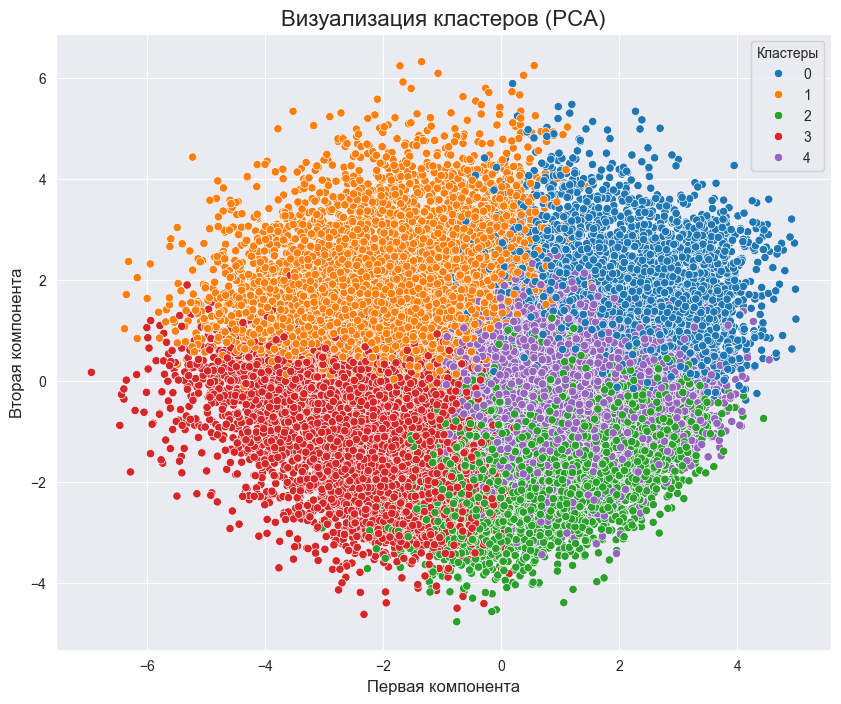

In [88]:
# Визуализация кластеров с использованием PCA
visualize_clusters(embeddings, df, method="PCA")

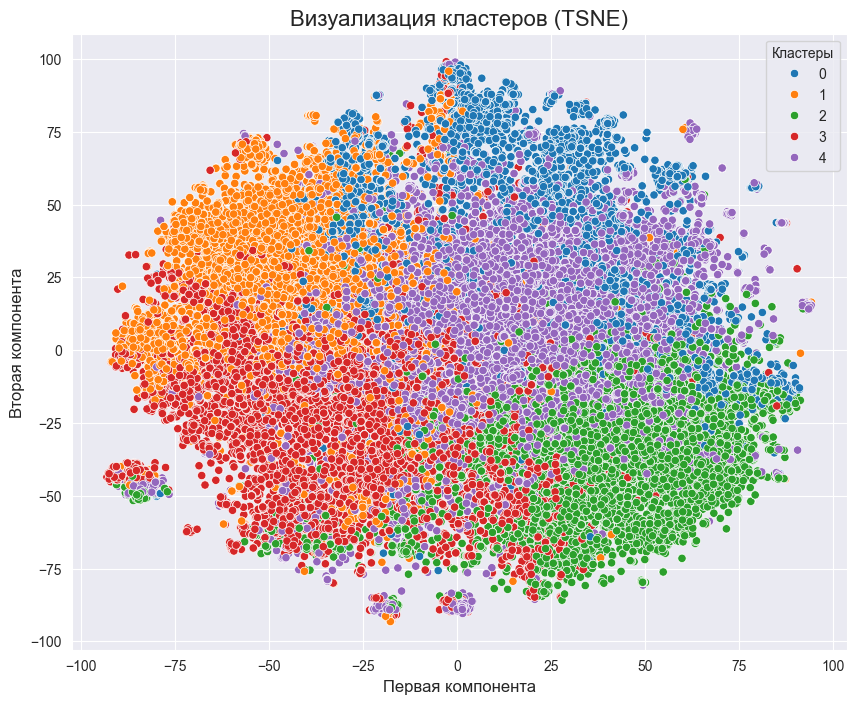

In [89]:
# Визуализация кластеров с использованием t-SNE
visualize_clusters(embeddings, df, method="TSNE")

In [90]:
df.to_parquet(folder_path + 'data_with_clasters2.parquet', index=False, engine="pyarrow")

In [91]:
df = pd.read_parquet(folder_path + 'data_with_clasters2.parquet')
df

,title,author_full_name,items,description,typology,author,date_category,key_words,embeddings,cluster
0,Декоративный мотив.,"[""Малевич Казимир Северинович 1879-1935""]","бумага, тушь",В вертикальной прямоугольной рамке декоративный мотив (центральная часть - в виде чёрного стержня с нанизанными на него дисками),графика,Малевич,1-я пол.20,"мотив,декоративный,нанизанными,стержень,диск,центральный,прямоугольный,вертикальный,рамка,чёрный,вид,часть,Малевич","[1.0375497, 0.06514211, 0.6857159, -0.11629645, -0.5514033, 1.0471567, -0.033659466, -0.7717726, 0.46907043, 0.6476442, -0.0062597925, 0.048025787, 0.4506426, 0.08214628, 0.096501514, -0.6963587, 0.47483462, 0.12824342, 0.40710723, 0.14754927, -0.26892316, 0.66398585, 0.06618212, 0.25025454, -0.09801163, -0.06287996, -1.2896776, -0.4990395, -0.30099693, -0.107096985, -0.011150629, 0.06091568, 0.6459023, -0.004164636, -0.44143844, 0.39752188, -0.04525373, -0.52683836, -0.293506, 0.95202494, -0.3880151, -0.050208554, 0.16577834, 0.2347445, 0.16343004, -0.30750886, 0.1921446, 0.370629, -0.6085293, -0.6587533, 0.3959642, 0.037651315, 0.3131981, -0.52652377, -0.47310227, -0.06551409, -0.49399728, -0.45614225, 0.48048723, 0.33525366, -0.18026128, -0.49397433, -0.40897185, 0.22188568, -0.71085167, 0.08599152, 0.15893023, -0.61558366, 0.57278067, 0.22088385, -1.1666098, 0.84117347, -0.6008721, -0.58954585, 0.18315369, 0.92709863, 0.42713654, 0.22434552, 0.45187214, -0.43246174, -0.25564602, -0.62885785, 0.7924565, 0.84808344, -0.45349783, -0.33550733, -0.0041214526, -0.9105722, 0.48174512, -1.3493668, -0.6096928, 0.2738434, 0.3039856, 0.5899973, -0.5460171, 0.5829893, 0.023837704, -0.17761345, -0.14451359, 0.47817618, ...]",3
1,Женский портрет в шляпе с пером. На обороте: На обороте: Фигура женщины с младенцем на руках,"[""Малевич Казимир Северинович (1879-1935)""]","бумага, графитный карандаш, растушевка","Портрет женщины в шляпе с пером (фронтально, оплечно). Изображение очерчено. На обороте: На обороте: в левой части листа - стоящая женщина с младенцем на руках.",графика,Малевич,2-я пол.20,"младенец,оборот,шляпа,женщина,портрет,пером,перо,стоящий,оплечный,очертить,рука,фронтальный,женский,часть,фигура,Малевич","[0.44638625, -0.029250745, 0.72633857, -0.004611733, -0.58378524, 0.8726067, -0.2623831, -0.5404644, 0.5453443, 0.7943348, 0.022009322, 0.0018289341, 0.22833079, -0.15913744, -0.0029457305, -0.37102467, 0.3409244, 0.8638428, 0.16379297, 0.32429942, -0.30685988, 0.59966105, 0.14323899, -0.2812118, -0.008019773, 0.18463661, -0.84705925, -0.41504836, -0.2033122, -0.19481558, -0.15489359, 0.059856176, 0.8527961, 0.1722964, -0.7348584, 0.50429034, -0.28521582, -0.20086804, -0.33708715, 1.1803501, -1.0219655, -0.11240461, 0.3799199, 0.21626605, -0.079799294, -0.5184722, -0.050741524, 0.6051096, -0.44082993, -0.5437437, 0.4473888, 0.64925927, 0.15978414, -0.57966477, -0.2952095, -0.086345494, -0.6604851, -0.2918408, 0.6456003, 0.07255597, -0.011347466, 0.16052291, -0.1564795, 0.2737341, -0.68075186, 0.053057056, 0.21953723, -1.0769848, 0.26953843, -0.058846273, -0.8788946, 0.5062883, -0.17353766, -0.22032225, 0.37992433, 0.83899426, 0.5005892, 0.12865515, -0.0019412622, -0.5445053, -0.41157663, -0.3407469, -0.19889705, 0.39764562, -0.6949506, -0.4162581, -0.18212713, -0.9419582, 0.530304, -1.005687, -0.122467555, 0.7584758, 0.27674705, 0.50957096, -1.1474992, 0.27270338, -0.07654729, -0.2836301, -0.28600037, 0.10738637, ...]",3
2,Декоративные мотивы. Три виньетки,"[""Малевич Казимир Северинович (1879-1935)""]","бумага верже, тушь, перо",Три виньетки. Слева: овальная виньетка с цветочным орнаментом. Справа внизу: виньетка в прямоугольной узкой рамке с двумя рядами симметрично расположенных цветов. Справа вверху: виньетка в прямоугольной рамке со стилизованным растением с тремя стеблями.,графика,Малевич,1-я пол.20,"виньетка,прямоугольный,три,стеблями,рамка,симметрично,цветочный,расположенных,растение,стилизованный,мотив,декоративный,овальный,узкий,орнамент,Малевич","[0.77163, 0.372871

In [92]:
df_to_merge = pd.read_csv('./data/data_for_database.csv', sep=';', encoding='utf-8')

In [93]:
df_to_merge

,title,items,description,image_url,catalog_num,registration_date,typology,author_lastname,author_name,author_patronymic,date_category,key_words
0,Декоративный мотив.,"бумага, тушь",В вертикальной прямоугольной рамке декоративный мотив (центральная часть - в виде чёрного стержня с нанизанными на него дисками),http://goskatalog.ru/muzfo-imaginator/rest/images/original/41451714,10479770.0,2018-01-31T12:54:54.729Z,графика,Малевич,Казимир,Северинович,1-я пол.20,"мотив,декоративный,нанизанными,стержень,диск,центральный,прямоугольный,вертикальный,него,рамка,чёрный,вид,часть,на"
1,Женский портрет в шляпе с пером. На обороте: На обороте: Фигура женщины с младенцем на руках,"бумага, графитный карандаш, растушевка","Портрет женщины в шляпе с пером (фронтально, оплечно). Изображение очерчено. На обороте: На обороте: в левой части листа - стоящая женщина с младенцем на руках.",http://goskatalog.ru/muzfo-imaginator/rest/images/original/41451687,10479769.0,2018-01-31T12:54:54.729Z,графика,Малевич,Казимир,Северинович,2-я пол.20,"младенец,оборот,шляпа,на,женщина,портрет,пером,перо,оплечный,очертить,стоящий,рука,фронтальный,женский,часть,фигура,левый,лист,изображение"
2,Декоративные мотивы. Три виньетки,"бумага верже, тушь, перо",Три виньетки. Слева: овальная виньетка с цветочным орнаментом. Справа внизу: виньетка в прямоугольной узкой рамке с двумя рядами симметрично расположенных цветов. Справа вверху: виньетка в прямоугольной рамке со стилизованным растением с тремя стеблями.,http://goskatalog.ru/muzfo-imaginator/rest/images/original/41451754,10479768.0,2018-01-31T12:54:54.729Z,графика,Малевич,Казимир,Северинович,1-я пол.20,"виньетка,прямоугольный,три,стеблями,рамка,симметрично,цветочный,расположенных,растение,стилизованный,мотив,декоративный,овальный,узкий,орнамент,ряд,цвет,справа,со,вверху"
3,Два женских портрета.,"бумага, черные чернила","Один под другим, в рамках: два женских портрета погрудно, анфас. У изображенной вверху голова чуть склонена влево, платье имеет открытый вырез. У изображенной ниже распущенные вьющиеся недлинные волосы и платье с широкими рукавами.",http://goskatalog.ru/muzfo-imaginator/rest/images/original/41451750,10479767.0,2018-01-31T12:54:54.729Z,графика,Малевич,Казимир,Северинович,1-я пол.20,"изображенной,недлинный,распущенные,платье,женский,иметь,портрет,другим,вырез,виться,чуть,рукав,склонить,погрудно,два,анфас,широкий,открытый,один,рамка"
4,Женский портрет (погрудный).,"бумага, бумага цветная, тушь, гуашь, наклейка",В круге: на фоне с цветочными узорами - поясной портрет дамы в тёмном платье в крапинку с цветной вставкой на груди (3/4 влево). Круг наклеен на тонкий коричневатый картон.,http://goskatalog.ru/muzfo-imaginator/rest/images/original/41451725,10479766.0,2018-01-31T12:54:54.729Z,графика,Малевич,Казимир,Северинович,2-я пол.20,"круг,крапинка,вставка,цветочный,картон,портрет,узор,коричневатый,наклеить,тонкий,цветной,дама,грудь,тёмный,поясной,платье,женский,погрудный,на,фон"
...,...,...,...,...,...,...,...,...,...,...,...,...
35702,Портрет Анны Андреевны Ахматовой.,"холст, масло","Ахматова изображена по плечи, с поворотом слегка вправо, взгляд на зрителя. Черные волосы подстрижены на лбу, нос с горбинкой. Темное платье с отложным воротником и с вырезом у шеи. На синем фоне справа синее изображение женщины со склоненной головой.",http://goskatalog.ru/muzfo-imaginator/rest/images/original/56377421,9876002.0,2017-12-11T11:44:01.596Z,живопись,Петров-Водкин,Кузьма,Сергеевич,1-я пол.20,"ахматов,синий,подстричь,горбинка,андреевич,отложной,плечи,анна,взгляд,вырез,склонить,лоб,шея,воротник,нос,поворот,слегка,тёмный,платье,зритель"
35703,Зима.,"холст, масло",Городской пейзаж. На первом плане: справа руины дома и ствол дерева; в середине стоят полуразрушенные ворота; слева серый дом с разбитыми стеклами. На втором плане кирпичная круглая башня и два дома. Перед домами обнаженные деревья. Все покрыто снегом. Небо серое.,http://goskatalog.ru/muzfo-imaginator/rest/images/original/35290235,9876001.0,2017-12-11T11:44:01.59

In [94]:
df['author'].rename('author_lastname')
df['author_name'] = df_to_merge['author_name']
df['author_patronymic'] = df_to_merge['author_patronymic']
df['catalog_num'] = df_to_merge['catalog_num']
df['registration_date'] = df_to_merge['registration_date']
df['image_url'] = df_to_merge['image_url']
df["registration_date"] = pd.to_datetime(df["registration_date"])
df

,title,author_full_name,items,description,typology,author,date_category,key_words,embeddings,cluster,author_name,author_patronymic,catalog_num,registration_date,image_url
0,Декоративный мотив.,"[""Малевич Казимир Северинович 1879-1935""]","бумага, тушь",В вертикальной прямоугольной рамке декоративный мотив (центральная часть - в виде чёрного стержня с нанизанными на него дисками),графика,Малевич,1-я пол.20,"мотив,декоративный,нанизанными,стержень,диск,центральный,прямоугольный,вертикальный,рамка,чёрный,вид,часть,Малевич","[1.0375497, 0.06514211, 0.6857159, -0.11629645, -0.5514033, 1.0471567, -0.033659466, -0.7717726, 0.46907043, 0.6476442, -0.0062597925, 0.048025787, 0.4506426, 0.08214628, 0.096501514, -0.6963587, 0.47483462, 0.12824342, 0.40710723, 0.14754927, -0.26892316, 0.66398585, 0.06618212, 0.25025454, -0.09801163, -0.06287996, -1.2896776, -0.4990395, -0.30099693, -0.107096985, -0.011150629, 0.06091568, 0.6459023, -0.004164636, -0.44143844, 0.39752188, -0.04525373, -0.52683836, -0.293506, 0.95202494, -0.3880151, -0.050208554, 0.16577834, 0.2347445, 0.16343004, -0.30750886, 0.1921446, 0.370629, -0.6085293, -0.6587533, 0.3959642, 0.037651315, 0.3131981, -0.52652377, -0.47310227, -0.06551409, -0.49399728, -0.45614225, 0.48048723, 0.33525366, -0.18026128, -0.49397433, -0.40897185, 0.22188568, -0.71085167, 0.08599152, 0.15893023, -0.61558366, 0.57278067, 0.22088385, -1.1666098, 0.84117347, -0.6008721, -0.58954585, 0.18315369, 0.92709863, 0.42713654, 0.22434552, 0.45187214, -0.43246174, -0.25564602, -0.62885785, 0.7924565, 0.84808344, -0.45349783, -0.33550733, -0.0041214526, -0.9105722, 0.48174512, -1.3493668, -0.6096928, 0.2738434, 0.3039856, 0.5899973, -0.5460171, 0.5829893, 0.023837704, -0.17761345, -0.14451359, 0.47817618, ...]",3,Казимир,Северинович,10479770.0,2018-01-31 12:54:54.729000+00:00,http://goskatalog.ru/muzfo-imaginator/rest/images/original/41451714
1,Женский портрет в шляпе с пером. На обороте: На обороте: Фигура женщины с младенцем на руках,"[""Малевич Казимир Северинович (1879-1935)""]","бумага, графитный карандаш, растушевка","Портрет женщины в шляпе с пером (фронтально, оплечно). Изображение очерчено. На обороте: На обороте: в левой части листа - стоящая женщина с младенцем на руках.",графика,Малевич,2-я пол.20,"младенец,оборот,шляпа,женщина,портрет,пером,перо,стоящий,оплечный,очертить,рука,фронтальный,женский,часть,фигура,Малевич","[0.44638625, -0.029250745, 0.72633857, -0.004611733, -0.58378524, 0.8726067, -0.2623831, -0.5404644, 0.5453443, 0.7943348, 0.022009322, 0.0018289341, 0.22833079, -0.15913744, -0.0029457305, -0.37102467, 0.3409244, 0.8638428, 0.16379297, 0.32429942, -0.30685988, 0.59966105, 0.14323899, -0.2812118, -0.008019773, 0.18463661, -0.84705925, -0.41504836, -0.2033122, -0.19481558, -0.15489359, 0.059856176, 0.8527961, 0.1722964, -0.7348584, 0.50429034, -0.28521582, -0.20086804, -0.33708715, 1.1803501, -1.0219655, -0.11240461, 0.3799199, 0.21626605, -0.079799294, -0.5184722, -0.050741524, 0.6051096, -0.44082993, -0.5437437, 0.4473888, 0.64925927, 0.15978414, -0.57966477, -0.2952095, -0.086345494, -0.6604851, -0.2918408, 0.6456003, 0.07255597, -0.011347466, 0.16052291, -0.1564795, 0.2737341, -0.68075186, 0.053057056, 0.21953723, -1.0769848, 0.26953843, -0.058846273, -0.8788946, 0.5062883, -0.17353766, -0.22032225, 0.37992433, 0.83899426, 0.5005892, 0.12865515, -0.0019412622, -0.5445053, -0.41157663, -0.3407469, -0.19889705, 0.39764562, -0.6949506, -0.4162581, -0.18212713, -0.9419582, 0.530304, -1.005687, -0.122467555, 0.7584758, 0.27674705, 0.50957096, -1.1474992, 0.27270338, -0.07654729, -0.2836301, -0.28600037, 0.10738637, ...]",3,Казимир,Северинович,10479769.0,2018-01-31 12:54:54.729000+00:00,http://goskatalog.ru/muzfo-imaginator/rest/images/original/41451687
2,Декоративные мотивы. Три виньетки,"[""Малевич Казимир Северинович (1879-1935)""]","бумага верже, тушь, перо",Три виньетки. Слева: овальная виньетка с цветочным орнаментом. Справа внизу: виньетка в прямоугольной узкой рамке с двум

In [95]:
df.to_parquet(folder_path + '/data_for_database_final2.parquet', index=False, engine="pyarrow")

In [32]:
df = pd.read_parquet(folder_path + '/data_for_database_final2.parquet')

## Сохранение в бд

In [97]:
!pip install python-dotenv sqlalchemy psycopg2


[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [168]:
from sqlalchemy import create_engine
from dotenv import load_dotenv
from sqlalchemy.orm import sessionmaker

# Загружаем переменные окружения из .env файла
load_dotenv()

# Получаем параметры из окружения
db_host = os.getenv('DB_HOST')
db_port = os.getenv('DB_PORT')
db_name = os.getenv('DB_NAME')
db_user = os.getenv('DB_USERNAME')
db_password = os.getenv('DB_PASSWORD')

# Формируем строку подключения для PostgreSQL
DATABASE_URL = f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'

# Создание подключения к базе данных
engine = create_engine(DATABASE_URL)

In [169]:
Session = sessionmaker(bind=engine)
session = Session()

In [156]:
df['embeddings'] = df['embeddings'].apply(lambda x: x.tolist())

In [170]:
try:
    chunksize = 10  # Размер батча
    num_chunks = len(df) // chunksize + 1

    # Создаем прогресс-бар с tqdm
    with tqdm(total=num_chunks, desc="Загрузка в PostgreSQL") as pbar:
        for start in range(0, len(df), chunksize):
            df.iloc[start:start + chunksize].to_sql("images", engine, if_exists="append", index=True, index_label="id",
                                                    chunksize=chunksize)
            pbar.update(1)

    print("✅ Датасет загружен в PostgreSQL")
except Exception as e:
    session.rollback()
    print(f"❌ Ошибка: {e}")
finally:
    session.close()

Загрузка в PostgreSQL: 100%|██████████| 3571/3571 [59:23<00:00,  1.00it/s]  

✅ Датасет загружен в PostgreSQL


## Рекомендательная система KMeans

In [29]:
# Рекомендация экспонатов по кластеру
def recommend_by_cluster(query, data, kmeans_model, n_recommendations=10):
    # Получаем эмбеддинг запроса
    query_embedding = get_embeddings([query])

    # Приводим эмбеддинг к типу float32
    query_embedding = query_embedding.astype(np.float32)

    # Определяем кластер для запроса
    query_cluster = kmeans_model.predict(query_embedding)

    # Рекомендуем экспонаты из того же кластера
    recommended_items = data[data['cluster'] == query_cluster[0]].head(n_recommendations)
    return recommended_items


In [30]:
def lemmatize_text_spacy(text):
    doc = nlp(text.lower())  # Приводим к нижнему регистру
    lemmatized_words = [
        token.lemma_ for token in doc
        if token.is_alpha  # Убираем числа и знаки препинания
        and len(token.lemma_) > 1  # Исключаем отдельные буквы
        and token.lemma_ not in STOP_WORDS  # Исключаем стоп-слова
    ]
    return ' '.join(lemmatized_words)

In [33]:
# Пример: Рекомендуем экспонаты для пользователя с запросом
user_query = "картина, изображающая пейзаж с озером"
recommended_items = recommend_by_cluster(lemmatize_text_spacy(user_query), df, kmeans_model)
recommended_items[['title', 'author', 'date_category']]

,title,author,date_category
0,Декоративный мотив.,Малевич,1-я пол.20
1,Женский портрет в шляпе с пером. На обороте: Н...,Малевич,2-я пол.20
2,Декоративные мотивы. Три виньетки,Малевич,1-я пол.20
4,Женский портрет (погрудный).,Малевич,2-я пол.20
5,Стоящая женщина в длинном платье.,Малевич,1-я пол.20
6,Супрематизм. 19 f. Серия супрематических компо...,Малевич,1-я пол.20
7,Портрет крестьянина.,Малевич,1-я пол.20
8,"Эскиз к картине ""Жатва"".",Малевич,1-я пол.20
9,Этюд для декоративного мотива.,Малевич,1-я пол.20
11,Переход в небытие (безразличное состояние). Су...,Малевич,1-я пол.20


In [34]:
# Пример: Рекомендуем экспонаты для пользователя с запросом
user_query = "Хочу посмотреть изображение мужчины в историческом костюме."
recommended_items = recommend_by_cluster(lemmatize_text_spacy(user_query), df, kmeans_model)
recommended_items[['title', 'author', 'date_category']]

,title,author,date_category
0,Декоративный мотив.,Малевич,1-я пол.20
1,Женский портрет в шляпе с пером. На обороте: Н...,Малевич,2-я пол.20
2,Декоративные мотивы. Три виньетки,Малевич,1-я пол.20
4,Женский портрет (погрудный).,Малевич,2-я пол.20
5,Стоящая женщина в длинном платье.,Малевич,1-я пол.20
6,Супрематизм. 19 f. Серия супрематических компо...,Малевич,1-я пол.20
7,Портрет крестьянина.,Малевич,1-я пол.20
8,"Эскиз к картине ""Жатва"".",Малевич,1-я пол.20
9,Этюд для декоративного мотива.,Малевич,1-я пол.20
11,Переход в небытие (безразличное состояние). Су...,Малевич,1-я пол.20


## Рекомендательная система на основе KMeans + KNN

In [45]:
from sklearn.neighbors import NearestNeighbors

def recommend_by_kmeans_knn(query, data, embeddings, kmeans_model, n_recommendations=10):
    # Получаем целевую размерность из KMeans
    target_dim = kmeans_model.cluster_centers_.shape[1]

    # Получаем эмбеддинг запроса
    query_embedding = get_embeddings([query])


    # Определяем кластер для запроса
    query_cluster = kmeans_model.predict(query_embedding)

    # Получаем индексы объектов в этом кластере
    cluster_indices = np.where(kmeans_model.labels_ == query_cluster)[0]

    # Если embeddings - разреженная матрица, конвертируем в плотный массив
    if isinstance(embeddings, np.ndarray):
        cluster_embeddings = embeddings[cluster_indices]
    else:
        cluster_embeddings = np.asarray(embeddings.todense()[cluster_indices])

    # Создаем модель NearestNeighbors
    nn_model = NearestNeighbors(n_neighbors=n_recommendations, metric='cosine')
    nn_model.fit(cluster_embeddings)

    # Находим ближайших соседей для запроса в этом кластере
    distances, indices = nn_model.kneighbors(query_embedding)

    # Возвращаем рекомендованные объекты
    recommended_items = data.iloc[cluster_indices[indices.flatten()]]

    return recommended_items


In [108]:
# Пример: Рекомендуем экспонаты для пользователя с запросом
user_query = "картина, изображающая пейзаж с озером"

# Рекомендуем экспонаты, используя модель KMeans и KNN
recommended_items = recommend_by_kmeans_knn(user_query, df, embeddings, kmeans_model)

# Выводим рекомендованные экспонаты с нужными колонками
recommended_items[['title', 'author', 'date_category']]

,title,author,date_category
24008,Роща,Куинджи,1-я пол.20
13850,Автопортрет,Врубель,2-я пол.19
127,Автопортрет.,Рождественский,1-я пол.20
1373,После дождя. Этюд.,Куинджи,2-я пол.19
11493,Семейный портрет,Боровиковский,2-я пол.18
6117,Мужской портрет,Неизвестный,1-я пол.19
21131,Иллюстрация,с,1-я пол.20
25694,Натюрморт с рыбой.,Михайлов,2-я пол.20
10370,"Девочка в розовом. Этюд к картине ""Детвора""",Ткачев,2-я пол.20
26521,Сидящая натурщица,Мухина,1-я пол.20


In [46]:
# Пример: Рекомендуем экспонаты для пользователя с запросом
user_query = "картина, изображающая пейзаж с озером"
recommended_items = recommend_by_kmeans_knn(lemmatize_text_spacy(user_query), df, embeddings, kmeans_model)
recommended_items[['title', 'author', 'date_category']]

,title,author,date_category
24008,Роща,Куинджи,1-я пол.20
6117,Мужской портрет,Неизвестный,1-я пол.19
13850,Автопортрет,Врубель,2-я пол.19
1373,После дождя. Этюд.,Куинджи,2-я пол.19
127,Автопортрет.,Рождественский,1-я пол.20
21131,Иллюстрация,с,1-я пол.20
11493,Семейный портрет,Боровиковский,2-я пол.18
21099,Иллюстрация,с,1-я пол.20
25694,Натюрморт с рыбой.,Михайлов,2-я пол.20
26521,Сидящая натурщица,Мухина,1-я пол.20


In [47]:
# Пример: Рекомендуем экспонаты для пользователя с запросом
user_query = "Хочу посмотреть изображение мужчины в историческом костюме."
recommended_items = recommend_by_kmeans_knn(lemmatize_text_spacy(user_query), df, embeddings, kmeans_model)
recommended_items[['title', 'author', 'date_category']]

,title,author,date_category
21081,Иллюстрация,Жилин,1-я пол.20
28668,"""Николай I"".",Робинсон,Неизвестно
127,Автопортрет.,Рождественский,1-я пол.20
17320,"Инициалы ""Н"" и ""С""",Неизвестный,Неизвестно
8840,Александр I,Неизвестный,1-я пол.19
21131,Иллюстрация,с,1-я пол.20
8846,Александр I,Райт,1-я пол.19
13850,Автопортрет,Врубель,2-я пол.19
29350,Портрет В.И.Ленина,Аферов,1-я пол.20
5423,Флаг (эскиз),Л,1-я пол.20


# Функции для чат-бота

In [117]:
import numpy as np
import pandas as pd
import torch
import os
import joblib
from sklearn.neighbors import NearestNeighbors
from transformers import BertTokenizer, BertModel
from dotenv import load_dotenv
from sqlalchemy import create_engine
from pgvector.sqlalchemy import Vector
from sqlalchemy.orm import sessionmaker

In [118]:
# === Загрузка переменных окружения ===
load_dotenv()

db_host = os.getenv('DB_HOST')
db_port = os.getenv('DB_PORT')
db_name = os.getenv('DB_NAME')
db_user = os.getenv('DB_USERNAME')
db_password = os.getenv('DB_PASSWORD')

DATABASE_URL = f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'

# Создание подключения к БД
engine = create_engine(DATABASE_URL)
Session = sessionmaker(bind=engine)
session = Session()

In [119]:
# === Загрузка модели KMeans ===
kmeans_model = joblib.load("./data-copy/kmeans_model2.joblib")

# === Загрузка модели RuBERT ===
model_name = 'DeepPavlov/rubert-base-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [144]:
# === Функция для получения эмбеддингов запроса ===
def get_embeddings(query):
    inputs = tokenizer(query, padding=True, truncation=True, return_tensors="pt", max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.cpu().numpy()

In [146]:
# === Загрузка эмбеддингов из PostgreSQL ===
def load_embeddings():
    query = "SELECT catalog_num, title, author, date_category, embeddings FROM images"
    df = pd.read_sql(query, engine)
    print(df.columns)
    df['embeddings'] = df['embeddings'].apply(lambda x: np.array(x))
    return df

In [147]:
df = load_embeddings()

Index(['catalog_num', 'title', 'author', 'date_category', 'embeddings'], dtype='object')


In [148]:
# === Функция рекомендаций через KMeans + KNN без использования эмбеддингов ===
def recommend_by_kmeans_knn(query, kmeans_model, n_recommendations=5):
    # Получаем эмбеддинг запроса
    query_embedding = get_embeddings(query)
    query_embedding = query_embedding.astype(np.float32)
    # Определяем кластер для запроса
    query_cluster = kmeans_model.predict(query_embedding)[0]

    # Получаем индексы объектов в этом кластере
    query_cluster_indices = np.where(kmeans_model.labels_ == query_cluster)[0]

    # Строим модель KNN для ближайших соседей по кластеру (не загружая все эмбеддинги в память)
    nn_model = NearestNeighbors(n_neighbors=n_recommendations, metric='cosine')

    # Вместо загрузки всех эмбеддингов, подгружаем только те, что принадлежат кластеру
    embeddings_query_cluster = get_embeddings_for_indices(query_cluster_indices)

    nn_model.fit(embeddings_query_cluster)

    # Находим ближайших соседей
    distances, indices = nn_model.kneighbors(query_embedding)

    # Получаем индексы ближайших объектов в кластере
    recommended_indices = query_cluster_indices[indices.flatten()]

    return recommended_indices

In [172]:
# === Функция рекомендаций через KMeans + KNN без использования эмбеддингов ===
def recommend_by_kmeans_knn(query, kmeans_model, n_recommendations=5):
    # Получаем эмбеддинг запроса
    query_embedding = get_embeddings(query)
    query_embedding = query_embedding.astype(np.float32)

    # Преобразуем query_embedding в двумерный массив (1, N)
    query_embedding = query_embedding.reshape(1, -1)

    # Определяем кластер для запроса
    query_cluster = kmeans_model.predict(query_embedding)[0]

    # Получаем индексы объектов в этом кластере
    query_cluster_indices = np.where(kmeans_model.labels_ == query_cluster)[0]

    # Строим модель KNN для ближайших соседей по кластеру (не загружая все эмбеддинги в память)
    nn_model = NearestNeighbors(n_neighbors=n_recommendations, metric='cosine')

    # Вместо загрузки всех эмбеддингов, подгружаем только те, что принадлежат кластеру
    embeddings_query_cluster = get_embeddings_for_indices(query_cluster_indices)

    nn_model.fit(embeddings_query_cluster)

    # Находим ближайших соседей
    distances, indices = nn_model.kneighbors(query_embedding)

    # Получаем индексы ближайших объектов в кластере
    recommended_indices = query_cluster_indices[indices.flatten()]

    return recommended_indices


In [149]:
# Функция для получения эмбеддингов для выбранных индексов
def get_embeddings_for_indices(indices):
    # Получаем эмбеддинги из БД для объектов с данными индексами
    query = f"SELECT embeddings FROM images WHERE id IN ({','.join(map(str, indices))})"
    df = pd.read_sql(query, engine)

    # Преобразуем эмбеддинги в массив
    embeddings = np.vstack(df["embeddings"].apply(lambda x: np.array(x)).values)

    return embeddings

In [150]:
# === Функция получения экспонатов по индексам ===
def get_exhibits_by_indices(indices):
    return df.iloc[indices][["catalog_num", "title", "author", "date_category"]].to_dict(orient="records")

In [173]:
# === Пример использования ===
user_query = "картина, изображающая пейзаж с озером"
recommended_indices = recommend_by_kmeans_knn(user_query, kmeans_model)
recommended_exhibits = get_exhibits_by_indices(recommended_indices)

recommended_exhibits

ValueError: dtype='numeric' is not compatible with arrays of bytes/strings.Convert your data to numeric values explicitly instead.

In [174]:
from sklearn.metrics.pairwise import cosine_similarity

# === Функция рекомендаций через KMeans + Косинусное сходство ===
def recommend_by_kmeans_cosine(query, kmeans_model, n_recommendations=5):
    # Получаем эмбеддинг запроса
    query_embedding = get_embeddings(query)
    query_embedding = query_embedding.astype(np.float32)

    # Преобразуем query_embedding в двумерный массив (1, N), чтобы он подходил для cosine_similarity
    query_embedding = query_embedding.reshape(1, -1)

    # Определяем кластер для запроса
    query_cluster = kmeans_model.predict(query_embedding)[0]

    # Получаем индексы объектов в этом кластере
    query_cluster_indices = np.where(kmeans_model.labels_ == query_cluster)[0]

    # Вместо загрузки всех эмбеддингов, подгружаем только те, что принадлежат кластеру
    embeddings_query_cluster = get_embeddings_for_indices(query_cluster_indices)

    # Вычисляем косинусное сходство между эмбеддингом запроса и эмбеддингами объектов в кластере
    similarities = cosine_similarity(query_embedding, embeddings_query_cluster)

    # Получаем индексы ближайших объектов в кластере
    recommended_indices = query_cluster_indices[similarities.flatten().argsort()[-n_recommendations:][::-1]]

    return recommended_indices


In [176]:
# === Пример использования ===
user_query = "картина, изображающая пейзаж с озером"
recommended_indices = recommend_by_kmeans_cosine(user_query, kmeans_model)
recommended_exhibits = get_exhibits_by_indices(recommended_indices)

recommended_exhibits

ValueError: could not convert string to float: np.str_('{1.0375497341156006,0.06514210999011993,0.685715913772583,-0.1162964478135109,-0.551403284072876,1.0471566915512085,-0.03365946561098099,-0.7717726230621338,0.4690704345703125,0.6476442217826843,-0.006259792484343052,0.04802578687667847,0.45064258575439453,0.08214627951383591,0.09650151431560516,-0.6963586807250977,0.4748346209526062,0.12824341654777527,0.40710723400115967,0.14754927158355713,-0.26892316341400146,0.6639858484268188,0.06618212163448334,0.2502545416355133,-0.09801162779331207,-0.06287995725870132,-1.289677619934082,-0.49903950095176697,-0.30099692940711975,-0.10709698498249054,-0.011150629259645939,0.06091567873954773,0.6459022760391235,-0.004164636135101318,-0.4414384365081787,0.39752188324928284,-0.045253731310367584,-0.5268383622169495,-0.293505996465683,0.9520249366760254,-0.38801509141921997,-0.05020855367183685,0.16577833890914917,0.23474450409412384,0.16343003511428833,-0.3075088560581207,0.19214460253715515,0.3706290125846863,-0.6085293292999268,-0.6587532758712769,0.39596420526504517,0.037651315331459045,0.3131980895996094,-0.526523768901825,-0.47310227155685425,-0.06551408767700195,-0.4939972758293152,-0.45614224672317505,0.48048722743988037,0.33525365591049194,-0.1802612841129303,-0.49397432804107666,-0.4089718461036682,0.22188568115234375,-0.7108516693115234,0.0859915167093277,0.1589302271604538,-0.6155836582183838,0.5727806687355042,0.22088384628295898,-1.166609764099121,0.8411734700202942,-0.6008720993995667,-0.5895458459854126,0.1831536889076233,0.9270986318588257,0.42713654041290283,0.22434552013874054,0.4518721401691437,-0.4324617385864258,-0.2556460201740265,-0.6288578510284424,0.7924565076828003,0.8480834364891052,-0.45349782705307007,-0.335507333278656,-0.004121452569961548,-0.9105721712112427,0.4817451238632202,-1.3493667840957642,-0.6096928119659424,0.2738434076309204,0.303985595703125,0.5899972915649414,-0.5460171103477478,0.5829892754554749,0.023837704211473465,-0.17761345207691193,-0.1445135921239853,0.47817617654800415,-0.7360166311264038,-0.11794023215770721,1.1606695652008057,-0.5899249315261841,0.4321676790714264,-0.1923295557498932,-0.1375409960746765,-0.48995983600616455,-0.8608795404434204,1.1534736156463623,-0.2783506214618683,0.38085392117500305,0.048360660672187805,0.004093140363693237,-0.1439625471830368,-0.44557633996009827,0.3092341125011444,-0.5902323722839355,0.603881299495697,-0.2304840087890625,-0.31973427534103394,0.1362154185771942,-0.2556869685649872,0.7992480993270874,0.8094162940979004,-0.6110353469848633,-0.10219705104827881,0.02843729965388775,0.3467530608177185,0.3883172869682312,0.8161115646362305,-0.33889079093933105,-0.4404919147491455,-0.28398770093917847,-0.07637903094291687,-0.5722230672836304,0.38646647334098816,-0.03119867481291294,0.30967098474502563,-0.3268725574016571,-0.3487606942653656,0.1203593835234642,-0.07218524068593979,0.04166364669799805,-0.08821260929107666,-0.5963335037231445,-0.5298240780830383,-0.3089306950569153,-0.20473811030387878,-0.4885197877883911,0.0445517934858799,-0.2904592454433441,0.2123943269252777,0.0191245898604393,0.35610243678092957,-0.06133972480893135,-0.24133305251598358,-0.2125769555568695,-0.06847133487462997,0.505099892616272,0.2570386230945587,0.4123213291168213,-0.956918478012085,1.6078555583953857,0.5536822080612183,-0.5477854013442993,-0.24613814055919647,-0.08537222445011139,-0.07214920967817307,0.20881570875644684,0.35987475514411926,-0.6646202802658081,-0.6345831155776978,0.2800115644931793,0.1540793478488922,0.12268909066915512,0.44506943225860596,-0.348810613155365,0.12358416616916656,-0.16293856501579285,-0.4291049838066101,-0.20191408693790436,0.22775346040725708,0.6494729518890381,-0.3054856061935425,-0.19097062945365906,0.2115972340106964,0.20078794658184052,0.06986147165298462,-0.23997940123081207,0.09735457599163055,0.40967032313346863,-0.023378707468509674,0.24040856957435608,0.9112012386322021,0.09098219871520996,-0.37341469526290894,-0.879507303237915,-0.3501697778701782,0.0067907776683568954,-1.2821983098983765,0.3350908160209656,0.07316139340400696,-0.3192501664161682,0.15395306050777435,1.133660078048706,-0.5272595286369324,-0.670121431350708,-0.4586065411567688,-0.31769466400146484,-0.24099257588386536,0.9292189478874207,0.28192028403282166,0.1906343400478363,-0.852744460105896,0.7579816579818726,0.5406665205955505,-0.060190193355083466,0.24056389927864075,0.19021804630756378,0.4113597869873047,-0.08666827529668808,-0.19824892282485962,0.27091410756111145,-0.07508184015750885,0.34607991576194763,0.10718217492103577,0.4648364782333374,0.8065524697303772,-0.08020449429750443,-0.24918976426124573,-0.39382103085517883,0.2009427547454834,-0.377237468957901,0.20765534043312073,-0.12616735696792603,0.7543407678604126,-0.10306428372859955,-0.3029996156692505,0.7327632308006287,-1.1417877674102783,-0.5557646155357361,0.5070728063583374,0.7116153240203857,0.0286773182451725,0.03696533665060997,-0.3466988205909729,-0.5318101644515991,0.3725854158401489,-0.8171478509902954,-0.2649247646331787,-0.18698154389858246,-0.02153308130800724,-0.3303872346878052,-0.14052388072013855,0.038081247359514236,0.5298492908477783,-0.3157695531845093,0.2690315842628479,-0.08749900013208389,0.22778862714767456,-0.44522708654403687,-0.28187042474746704,0.4880603551864624,-0.3931056261062622,0.8973429203033447,-0.9319640398025513,-0.011329771019518375,-0.08497204631567001,-1.0330252647399902,0.2832827866077423,0.400825560092926,0.24743862450122833,0.6521891355514526,0.44956809282302856,0.18274259567260742,-0.23120614886283875,0.18409372866153717,-0.023952016606926918,-0.07789771258831024,-0.10075363516807556,0.26861870288848877,0.38829419016838074,0.30489715933799744,0.0051615191623568535,-0.7675824761390686,0.494853675365448,0.19780972599983215,0.012354288250207901,-0.30443376302719116,-0.5790441036224365,-0.9273343086242676,0.03695128485560417,0.12786774337291718,0.11326681077480316,-0.2988783121109009,-0.1203102320432663,0.15430094301700592,-0.6596550941467285,-0.2053745687007904,0.38580530881881714,0.0670362040400505,0.3872491121292114,0.3548572063446045,-0.16590651869773865,0.16476356983184814,0.8591298460960388,-0.9576606750488281,0.4849582314491272,-0.3376423120498657,-1.0214987993240356,0.4839766025543213,-0.31004080176353455,0.20313522219657898,-0.21464049816131592,-0.01044372282922268,0.4121659994125366,0.42806708812713623,0.11155226826667786,0.29376259446144104,-0.26414161920547485,-0.0028369296342134476,-0.11651311069726944,-0.47074300050735474,0.8652117252349854,-0.11932177096605301,-1.3092713356018066,-0.2226317822933197,-0.161252960562706,0.3885729908943176,-0.7142095565795898,-0.8606570959091187,-0.02291194163262844,-0.24380865693092346,-0.276874840259552,0.12704741954803467,-0.2652871012687683,-0.23847976326942444,-0.29826343059539795,0.0387953519821167,0.18639829754829407,0.03231212496757507,0.9289267063140869,-0.10789382457733154,0.40006008744239807,-0.15272115170955658,-0.23669523000717163,-0.3558514714241028,-0.7663851976394653,0.1396791636943817,-0.299995481967926,0.05872775614261627,-0.12513312697410583,-0.0939585417509079,0.1866041123867035,0.3649716377258301,-0.06935343891382217,-0.47438913583755493,0.4104141891002655,-0.16044797003269196,-0.22948578000068665,-0.3386523127555847,-0.23128993809223175,-0.5397235155105591,-0.15895530581474304,-0.09140052646398544,-0.4080261290073395,-0.5727304220199585,0.103849858045578,-0.7865170240402222,0.4533895254135132,0.3880498707294464,0.14009307324886322,-0.19314733147621155,0.1050192266702652,-0.1115543320775032,0.6545698642730713,-0.04052746295928955,0.525032639503479,0.044795893132686615,0.528434157371521,-0.8487895131111145,0.3636273741722107,-0.06132896989583969,-0.10147389769554138,-0.36996006965637207,0.6070080995559692,-0.1570768654346466,-0.5611753463745117,-0.15863579511642456,0.1174568235874176,-0.10020660609006882,-0.03212606906890869,-0.17187736928462982,-0.0029239989817142487,0.3686513304710388,0.3321382999420166,0.16150420904159546,0.33964869379997253,-0.3043946921825409,0.019996827468276024,0.9397265911102295,0.699636697769165,-0.04738499969244003,-0.21447090804576874,-0.030482014641165733,1.2699720859527588,0.36960214376449585,-0.06431104242801666,0.5644785165786743,-0.14577513933181763,-0.37775760889053345,0.22803595662117004,0.5397775173187256,0.1322668045759201,-0.0027732504531741142,-0.8486994504928589,0.16623280942440033,-0.09165491908788681,0.5527220964431763,0.7865495681762695,-0.19874165952205658,0.5650426149368286,-2.3641114234924316,-0.37301337718963623,0.41497090458869934,0.0026661809533834457,0.10002750158309937,-0.02313505858182907,-0.04099241644144058,-0.7911399602890015,0.017656616866588593,0.0395013727247715,0.23953476548194885,0.3014732003211975,-0.5255557298660278,0.08339880406856537,-0.0017090905457735062,-0.36023396253585815,0.6670083403587341,0.19104737043380737,0.47766613960266113,0.43993622064590454,-0.17888741195201874,0.3381475806236267,-0.8452540040016174,0.3570438027381897,-1.419027328491211,-0.3436477780342102,0.7534453868865967,-0.34784844517707825,-1.0138827562332153,-0.1631530374288559,-0.809758186340332,-0.6972942352294922,-0.14128588140010834,-0.6242976188659668,0.46321436762809753,0.36111149191856384,-0.21863050758838654,0.362603098154068,0.11501568555831909,-0.5136447548866272,0.2562912404537201,-0.057439468801021576,0.02484690397977829,0.49630171060562134,0.00813668966293335,-0.04029393196105957,0.3367537260055542,-0.010464534163475037,0.5258078575134277,0.07877219468355179,-0.597377359867096,-1.3464765548706055,-0.127922922372818,0.39095768332481384,-0.013755982741713524,0.07523190975189209,-0.06193885952234268,-0.19209584593772888,1.1849033832550049,0.6237789988517761,-1.0586483478546143,-0.22977787256240845,0.9154844284057617,0.2889626622200012,0.3984884023666382,0.3797664940357208,0.653618335723877,0.2901849150657654,-0.3317377269268036,-0.35428398847579956,0.1806124746799469,-0.08163441717624664,0.5065104961395264,0.0442754402756691,-0.12036954611539841,0.40897729992866516,0.4053255021572113,-0.1951855570077896,0.7892069816589355,-0.17255155742168427,0.28649014234542847,-0.5826651453971863,0.02442609891295433,-0.43280836939811707,-0.5097442269325256,-0.12231872975826263,0.3570706844329834,-0.5866824388504028,-0.5492348670959473,-0.8552281260490417,0.278510183095932,-0.6040905714035034,0.1326640397310257,-0.1831754893064499,0.2266119122505188,-0.07500771433115005,-0.20111161470413208,0.5697823166847229,-0.0709015429019928,0.3027397394180298,0.4478912353515625,-0.21101140975952148,-0.2086341381072998,-0.40875208377838135,-0.6963454484939575,0.21275463700294495,-0.08772650361061096,-0.15271064639091492,0.28574520349502563,-0.7438710927963257,0.47454339265823364,0.3204256594181061,-0.05126742273569107,-0.44891682267189026,-1.1238287687301636,0.042242325842380524,0.16265903413295746,-0.8090157508850098,0.4796893000602722,-0.4960464835166931,-0.5887223482131958,0.0057855211198329926,-0.011411147192120552,0.0629768967628479,-0.02945876494050026,0.3772909641265869,0.18598324060440063,0.08601482957601547,0.3253067433834076,-0.07288950681686401,0.5107650756835938,-0.27896231412887573,0.8208357095718384,0.592596173286438,0.11916424334049225,-0.2079402059316635,0.05013899505138397,-0.2904241383075714,-0.09672826528549194,-0.14597594738006592,-0.4219963550567627,-0.12915761768817902,-0.3224146366119385,-0.510074257850647,1.1039936542510986,0.23514963686466217,0.06237412244081497,0.09331273287534714,-0.7101713418960571,-0.27134692668914795,-0.04310327768325806,0.02265661582350731,0.25408971309661865,-0.33751869201660156,0.3841017186641693,0.25328394770622253,-0.07269904017448425,-0.013025250285863876,-0.23293012380599976,0.7179603576660156,-0.42837733030319214,-0.06219913065433502,0.5612750053405762,-0.7766281962394714,0.2774891257286072,-0.5948686599731445,0.4256975054740906,-0.27340900897979736,-0.4111620783805847,0.3827289938926697,0.4309593141078949,0.5772849321365356,0.07455495744943619,0.26092827320098877,-0.2234800010919571,0.7992016077041626,-0.2778744697570801,-0.4751584529876709,0.04661073163151741,0.2070854902267456,-0.08711952716112137,-0.22271612286567688,0.1274348646402359,0.3308068811893463,0.4041270613670349,0.172659233212471,0.15686871111392975,0.7019267678260803,-0.37646567821502686,-0.48133787512779236,0.3379548490047455,0.05260513722896576,-0.9662942886352539,-1.1339764595031738,-0.9190158247947693,-0.3559570610523224,-0.4457751214504242,0.39271074533462524,0.0003343820571899414,0.587059736251831,-1.6514285802841187,-0.06368005275726318,0.2955244779586792,-0.007528257090598345,-0.28513646125793457,0.34708625078201294,-0.675666332244873,-0.3086017966270447,0.34145066142082214,0.12748399376869202,-0.6930986046791077,0.5453193783760071,0.5002743005752563,-0.3944207429885864,-0.11963735520839691,0.02499205619096756,-0.8036983013153076,-0.08560235053300858,0.37813907861709595,0.11452832818031311,-0.37287017703056335,0.25359636545181274,0.4060995280742645,-0.35702788829803467,-0.08768638968467712,0.42463386058807373,0.8744235038757324,-0.5177407264709473,0.6756515502929688,0.24487973749637604,-0.19325388967990875,1.098376989364624,0.9754056930541992,0.017800016328692436,-0.5442667007446289,0.8799927234649658,0.25922325253486633,0.019139453768730164,0.5742809772491455,0.9643406867980957,-0.6803781986236572,-0.49947381019592285,0.9967077970504761,-0.9313172698020935,0.08722478151321411,0.5362812876701355,0.392419695854187,-0.5224521160125732,-0.33542439341545105,0.2740916609764099,-0.040676895529031754,0.46035099029541016,-0.2506856322288513,-0.2275424748659134,0.07055900990962982,-0.49813100695610046,-0.009532798081636429,-0.5796295404434204,0.2692495584487915,0.35090354084968567,0.592957615852356,0.2456626445055008,-0.036130618304014206,0.15002381801605225,-0.40779754519462585,0.17259062826633453,0.005904369056224823,0.5560798645019531,-0.4437752366065979,-0.5059412717819214,-0.9358370900154114,0.2636125087738037,0.547683596611023,0.3785043954849243,0.08023236691951752,0.23523488640785217,0.4317179322242737,0.007841653190553188,-0.7868745923042297,-0.14400020241737366,0.036458685994148254,0.4577055871486664,-0.0765785425901413,0.45621824264526367,0.03851054236292839,-0.05269116908311844,0.12810805439949036,0.7460347414016724,-0.13526582717895508,0.3283848762512207,0.4072592258453369,-0.10442111641168594,0.46124058961868286,0.01752651110291481,0.4018474817276001,0.25948622822761536,0.3247792422771454,0.11198854446411133,-0.874139666557312,-0.6515527963638306,0.28535619378089905,-0.46646416187286377,0.3272181749343872,0.17168983817100525,0.5283491015434265,-0.18744699656963348,0.7399147152900696,-0.18367999792099,-0.4066244065761566,-0.825859010219574,0.6251270771026611,0.12779274582862854,0.08262553811073303,-0.7727757096290588,0.11499512195587158,0.5527746081352234,0.7663229703903198,0.37103235721588135,-1.0139048099517822,-0.6426899433135986,0.7853565216064453,-0.051824767142534256,-0.1158706545829773,-0.18373271822929382,-0.1719854772090912,0.12586286664009094,-0.035763856023550034,-0.2629823088645935,-0.9756810069084167,-0.4526267647743225,-0.2745070457458496,-0.230424702167511,-0.20212483406066895,-0.19410806894302368,-0.09038589149713516,0.09682827442884445,-0.2737795114517212,-1.0938029289245605,-0.8489185571670532,-0.26916199922561646,0.15987403690814972,0.603334903717041,1.358846664428711,0.1561334878206253,0.08646343648433685}')

# вариант 2

In [1]:
import numpy as np
import pandas as pd
import torch
import os
import joblib
from sklearn.neighbors import NearestNeighbors
from transformers import BertTokenizer, BertModel
from dotenv import load_dotenv
from sqlalchemy import create_engine
from pgvector.sqlalchemy import Vector
from sqlalchemy.orm import sessionmaker
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

In [2]:
# === Загрузка переменных окружения ===
load_dotenv()

db_host = os.getenv('DB_HOST')
db_port = os.getenv('DB_PORT')
db_name = os.getenv('DB_NAME')
db_user = os.getenv('DB_USERNAME')
db_password = os.getenv('DB_PASSWORD')

DATABASE_URL = f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'

# Создание подключения к БД
engine = create_engine(DATABASE_URL)
Session = sessionmaker(bind=engine)
session = Session()

In [3]:
# === Загрузка модели KMeans ===
kmeans_model = joblib.load("./data-copy/kmeans_model2.joblib")

# === Загрузка модели RuBERT ===
model_name = 'DeepPavlov/rubert-base-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
# === Загрузка модели Spacy для лемматизации ===
nlp = spacy.load('ru_core_news_sm')

# === Список стоп-слов для TF-IDF ===
STOP_WORDS = nlp.Defaults.stop_words

In [5]:
# === Функция для лемматизации и очистки текста ===
def lemmatize_text_spacy(text):
    doc = nlp(text.lower())  # Приводим к нижнему регистру
    lemmatized_words = [
        token.lemma_ for token in doc
        if token.is_alpha  # Убираем числа и знаки препинания
        and len(token.lemma_) > 1  # Исключаем отдельные буквы
        and token.lemma_ not in STOP_WORDS  # Исключаем стоп-слова
    ]
    return ' '.join(lemmatized_words)

In [6]:
# === Функция для получения эмбеддингов запроса ===
def get_embeddings(query):
    inputs = tokenizer(query, padding=True, truncation=True, return_tensors="pt", max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.cpu().numpy()

In [7]:
# === Загрузка эмбеддингов из PostgreSQL ===
def load_embeddings():
    query = "SELECT catalog_num, title, author, date_category, embeddings FROM images"
    df = pd.read_sql(query, engine)
    df['embeddings'] = df['embeddings'].apply(lambda x: np.array(x))
    return df

In [8]:
df = load_embeddings()
embeddings = np.vstack(df["embeddings"].values)

In [9]:
# === Функция для извлечения ключевых слов с использованием TF-IDF ===
def extract_keywords_with_tfidf(df, top_n=15):
    # Объединяем описание и название в единый текст и лемматизируем
    df['combined_text'] = df['description'] + ' ' + df['title']
    df['lemmatized_text'] = df['combined_text'].apply(lemmatize_text_spacy)

    # Инициализируем TF-IDF векторизатор с русскими стоп-словами
    vectorizer = TfidfVectorizer(stop_words=list(STOP_WORDS))
    tfidf_matrix = vectorizer.fit_transform(df['lemmatized_text'])
    feature_names = vectorizer.get_feature_names_out()

    df['key_words'] = ''

    for index in tqdm(range(len(df)), total=len(df), desc="Processing rows", ncols=100):
        # Получаем TF-IDF веса для текущей строки
        tfidf_vector = tfidf_matrix[index].toarray().flatten()
        top_indices = tfidf_vector.argsort()[-top_n:][::-1]

        # Извлекаем ключевые слова
        key_words = [feature_names[i] for i in top_indices if tfidf_vector[i] > 0]

        # Сохраняем ключевые слова
        df.at[index, 'key_words'] = ','.join(key_words)

    # Удаляем временные колонки
    df.drop(columns=['combined_text', 'lemmatized_text'], inplace=True)

    return df

In [10]:
# === Функция рекомендаций через KMeans + KNN ===
def recommend_by_kmeans_knn(query, embeddings, kmeans_model, n_recommendations=5):
    # Преобрабатываем запрос
    preprocessed_query = lemmatize_text_spacy(query)

    # Получаем эмбеддинг для обработанного запроса
    query_embedding = get_embeddings([preprocessed_query])

    # Определяем кластер запроса
    query_cluster = kmeans_model.predict(query_embedding)[0]

    # Находим индексы экспонатов из этого кластера
    cluster_indices = np.where(kmeans_model.labels_ == query_cluster)[0]
    cluster_embeddings = embeddings[cluster_indices]

    # Используем KNN для поиска ближайших экспонатов
    nn_model = NearestNeighbors(n_neighbors=n_recommendations, metric='cosine')
    nn_model.fit(cluster_embeddings)

    distances, indices = nn_model.kneighbors(query_embedding)
    recommended_indices = cluster_indices[indices.flatten()]

    return recommended_indices

In [11]:
# === Функция получения экспонатов по индексам ===
def get_exhibits_by_indices(indices):
    return df.iloc[indices][["catalog_num", "title", "author", "date_category"]].to_dict(orient="records")

In [12]:
# === Пример использования ===
user_query = "картина, изображающая пейзаж с озером"
recommended_indices = recommend_by_kmeans_knn(user_query, embeddings, kmeans_model)
recommended_exhibits = get_exhibits_by_indices(recommended_indices)

print(recommended_exhibits)

ValueError: dtype='numeric' is not compatible with arrays of bytes/strings.Convert your data to numeric values explicitly instead.

In [13]:
# === Пример использования ===
user_query = "Хочу посмотреть изображение мужчины в историческом костюме."
recommended_indices = recommend_by_kmeans_knn(user_query, embeddings, kmeans_model)
recommended_exhibits = get_exhibits_by_indices(recommended_indices)

print(recommended_exhibits)


ValueError: dtype='numeric' is not compatible with arrays of bytes/strings.Convert your data to numeric values explicitly instead.